In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2
import matplotlib.pyplot as plt
from matplotlib.pyplot import imshow
plt.rcParams["figure.figsize"] = 10, 8
plt.rcParams["font.size"     ] = 14


In [2]:
import numpy as np
import pandas as pd
from collections import namedtuple
import os
import glob
from pathlib import Path

In [3]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from torchvision import transforms
from torchvision import datasets
from torch.utils.data.sampler import SubsetRandomSampler
from torchsummary import summary
from torchvision.transforms import v2


In [56]:
from pymono.cnns import x_cnn_evaluation, x_single_run, x_train_cnn
from pymono.cnns import Conv2dPars,  MaxPool2dPars,  LinealLayerPars
from pymono.cnns import build_conv_layer, build_conv_layers, build_linear_layers
from pymono.cnns import xCNN, xResNet10, xResNet8, ResBlock

In [104]:
from pymono.plt_funcs import  plot_loss, plot_accuracy, cifar_plot_image_and_label 
from pymono.plt_funcs import  plot_energies2, histoplot, plotxyz, plot_dataset
from pymono.cnn_plots import plot_images2, plot_images2c
from pymono.cnn_plots import plot2c_z, plot_images_and_labels, plot_images_and_positions

In [6]:
from pymono.cnn_aux import get_file_names_format1, get_image_file_data, get_img_file_metadata
from pymono.cnn_aux import get_energy2, get_means_stds2

In [177]:
from pymono.xdataset import XDataset, RDataset, R2Dataset
from pymono.mono_dl import mono_data_loader
from pymono.cnn_eval import evaluate_cnn, evaluate_2c_cnn, cnn_xeval, single_run, train_cnn

In [8]:
from pymono.cnn_func import CNN_basic
from pymono.cnn_func import  CNN

In [9]:
from pymono.cnn_eval import cnn_evaluation 

In [10]:
from pymono.cnn_fit import fit_coord, fit_tdeltas, plotfxyz

In [11]:
device = (
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)
print(f"Using {device} device")

Using cuda device


## Local functions

In [12]:
def print_features(train_loader):
    train_features, train_labels = next(iter(train_loader))
    print(f"Feature batch shape: {train_features.size()}")
    print(f"Labels batch shape: {train_labels.size()}")

## Voxelization at 12 mm
- df1c is the directory containing images and labels for events classified as single cluster (1c)
- df2c is the directory containing images and labels for events classified as double cluster (2c)
- dfnc is the directory containing images and labels for events classified as multiple cluster (nc)
- Files are in format1:
    - images files are of the form: images_n.npy, where n is a number.
    - labels are stored in a single file (labels.csv)
 
- Data corresponds to CsITl (50 k MeV rather than 100 k /MeV)

In [13]:
data_dir = Path(os.environ['MONOLITH_DATA'])
dir_root = os.path.join(data_dir,"CsI_6x6_fullwrap_50k_0MHzDC_PTFE_LUT_gamma_vox_12mm")
d1c = os.path.join(dir_root,"df1c")
d2c = os.path.join(dir_root,"df2c")
dnc = os.path.join(dir_root,"dfnc")

In [14]:
img_names, csv_name = get_file_names_format1(d1c)

In [15]:
img_names[0]

'/home/investigator/Data/monolithic_csi/CsI_6x6_fullwrap_50k_0MHzDC_PTFE_LUT_gamma_vox_12mm/df1c/images_1.npy'

In [16]:
csv_name

['/home/investigator/Data/monolithic_csi/CsI_6x6_fullwrap_50k_0MHzDC_PTFE_LUT_gamma_vox_12mm/df1c/df1c_12mm.csv']

### Label data
- When sorted by value, label data corresponds to the image stored in the directory.
- event_id = 10000 x image_number, so that event 1004 corresponds to the fourth image in file images_1.npy

In [17]:
df1c = pd.read_csv(csv_name[0])
df1c.head(10)

,event_id,e,x,y,z,t
0,10004,0.510118,18.645067,12.477487,29.249544,0.116340
1,10006,0.509274,13.566376,1.647984,21.156849,0.090734
2,10014,0.509922,-5.014233,5.060986,12.715019,0.062352
3,10018,0.508170,-22.957691,-9.322307,45.483715,0.171746
4,10024,0.508948,-3.514938,-0.639491,15.746504,0.074194
5,10026,0.508879,18.973616,-6.031100,16.421364,0.074508
6,10027,0.508849,11.437413,-22.155209,40.912632,0.157729
7,10028,0.509717,9.708068,3.101630,13.316263,0.064982
8,10029,0.509517,0.335767,-11.193620,21.898740,0.093051
9,10030,0.509092,16.716444,15.401320,25.922293,0.107143


#### Example
- Images and labels in first file of directory

In [18]:
imgs, imgf_path, imgf_name, imfn = get_image_file_data(img_names,img_file_index=0)
print(f"image file path = {imgf_path}")
print(f"image file name = {imgf_name}")
print(f"image file number = {imfn}")
print(f"number of images in file = {len(imgs)}")

df1cs = get_img_file_metadata(df1c, imfn)  # This are the events corresponding to the images
print(f"number of labels in file = {len(df1cs)}")


image file path = /home/investigator/Data/monolithic_csi/CsI_6x6_fullwrap_50k_0MHzDC_PTFE_LUT_gamma_vox_12mm/df1c/images_1.npy
image file name = images_1.npy
image file number = 1
number of images in file = 3032
number of labels in file = 3032


In [19]:
df1cs.head(10)

,event_id,e,x,y,z,t
0,10004,0.510118,18.645067,12.477487,29.249544,0.116340
1,10006,0.509274,13.566376,1.647984,21.156849,0.090734
2,10014,0.509922,-5.014233,5.060986,12.715019,0.062352
3,10018,0.508170,-22.957691,-9.322307,45.483715,0.171746
4,10024,0.508948,-3.514938,-0.639491,15.746504,0.074194
5,10026,0.508879,18.973616,-6.031100,16.421364,0.074508
6,10027,0.508849,11.437413,-22.155209,40.912632,0.157729
7,10028,0.509717,9.708068,3.101630,13.316263,0.064982
8,10029,0.509517,0.335767,-11.193620,21.898740,0.093051
9,10030,0.509092,16.716444,15.401320,25.922293,0.107143


In [20]:
df1cs.values[0]

array([1.00040000e+04, 5.10118200e-01, 1.86450670e+01, 1.24774870e+01,
       2.92495440e+01, 1.16340004e-01])

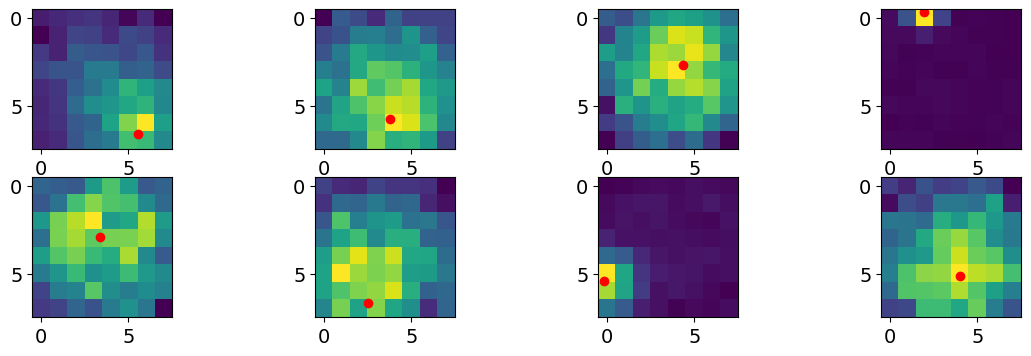

In [21]:
plot_images2(imgs, df1cs, (0,8), pixel_size = 6, grid_size=8)

In [22]:
energy = get_energy2(imgs)

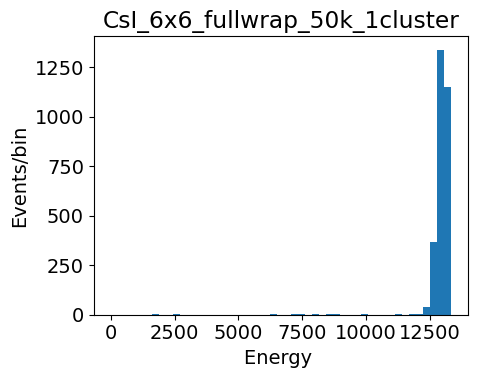

In [23]:
plot_energies2({"CsI_6x6_fullwrap_50k_1cluster":energy}, xmin=0, xmax=max(energy),num_bins = 50)

# Regression Studies

### Load data
- Use RDataset which stores (images, (x,y,z)).
- No normalization.
- No previous classification

In [24]:
first_file = 0  # initial file indx
last_file  = 100  # lasta file indx
batch_size = 100  # Batch size
train_fraction=0.7 
val_fraction=0.2

In [25]:
dataset = RDataset(dir_root, first_file, last_file,type="1c", norm=False)  

Running rDataset with norm = False
Loading files in directory d1c with indexes: 0, 100
   event_id         e          x          y          z         t
0     10004  0.510118  18.645067  12.477487  29.249544  0.116340
1     10006  0.509274  13.566376   1.647984  21.156849  0.090734
2     10014  0.509922  -5.014233   5.060986  12.715019  0.062352
3     10018  0.508170 -22.957691  -9.322307  45.483715  0.171746
4     10024  0.508948  -3.514938  -0.639491  15.746504  0.074194
5     10026  0.508879  18.973616  -6.031100  16.421364  0.074508
6     10027  0.508849  11.437413 -22.155209  40.912632  0.157729
7     10028  0.509717   9.708068   3.101630  13.316263  0.064982
8     10029  0.509517   0.335767 -11.193620  21.898740  0.093051
9     10030  0.509092  16.716444  15.401320  25.922293  0.107143
image name = images_1.npy
image number = 1
number of images in file = 3032
number of labels in file = 3032
meta =>[1.00040000e+04 5.10118200e-01 1.86450670e+01 1.24774870e+01
 2.92495440e+01 1.16340

In [26]:
dataset[3]

(tensor([[[ 179.,  718., 2478.,  585.,  124.,  140.,  127.,  117.],
          [ 172.,  173.,  314.,  170.,  149.,  129.,  131.,  121.],
          [ 161.,  127.,  136.,  149.,  149.,  152.,  114.,  120.],
          [ 148.,  141.,  153.,  124.,  129.,  150.,  130.,  128.],
          [ 130.,  132.,  163.,  169.,  143.,  138.,  138.,  143.],
          [ 162.,  154.,  148.,  162.,  152.,  137.,  136.,  144.],
          [ 123.,  140.,  124.,  153.,  138.,  141.,  144.,  133.],
          [ 146.,  147.,  160.,  127.,  129.,  123.,  134.,  142.]]]),
 tensor([-22.9577,  -9.3223,  45.4837]))

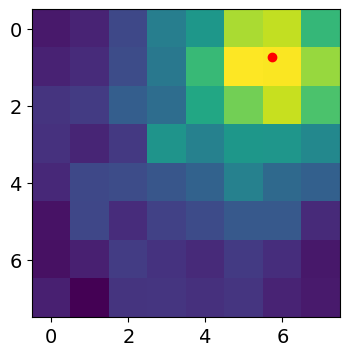

In [27]:
plot_dataset(dataset[15], pixel_size = 6, grid_size=8)

In [28]:
data_loader, train_loader, val_loader, test_loader = mono_data_loader(dataset, 
                                                                      batch_size=batch_size, 
                                                                      train_fraction=train_fraction, 
                                                                      val_fraction=val_fraction)

Loaded 305080 events
 train size = 213556
 val size = 61016
 test size = 30508
 train indices = range(0, 213556)
 val indices = range(213556, 274572)
 test indices = range(274572, 305080)
213556 training events (70.0%)
61016 validation events (20.0%)
30508 test events (10.0%)


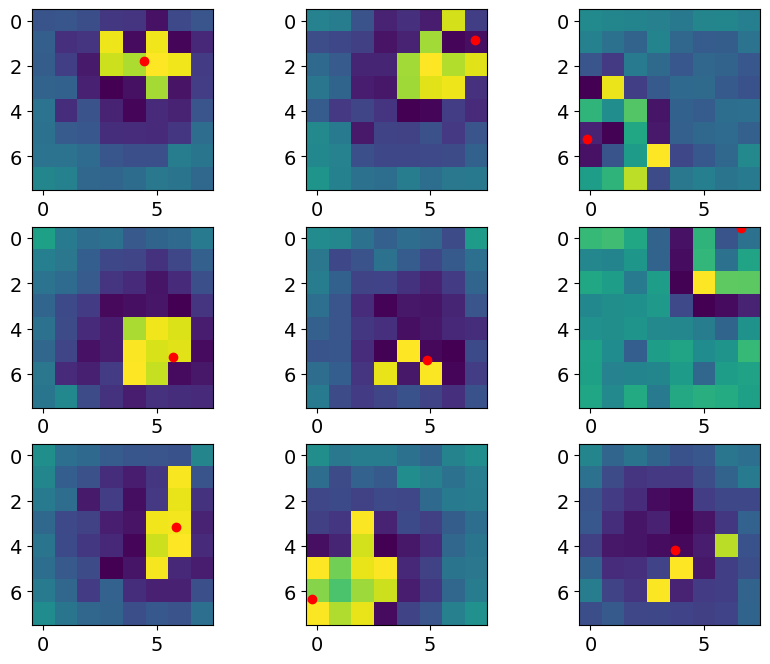

In [29]:
plot_images_and_positions(train_loader, start=0, figsize=(10, 8))

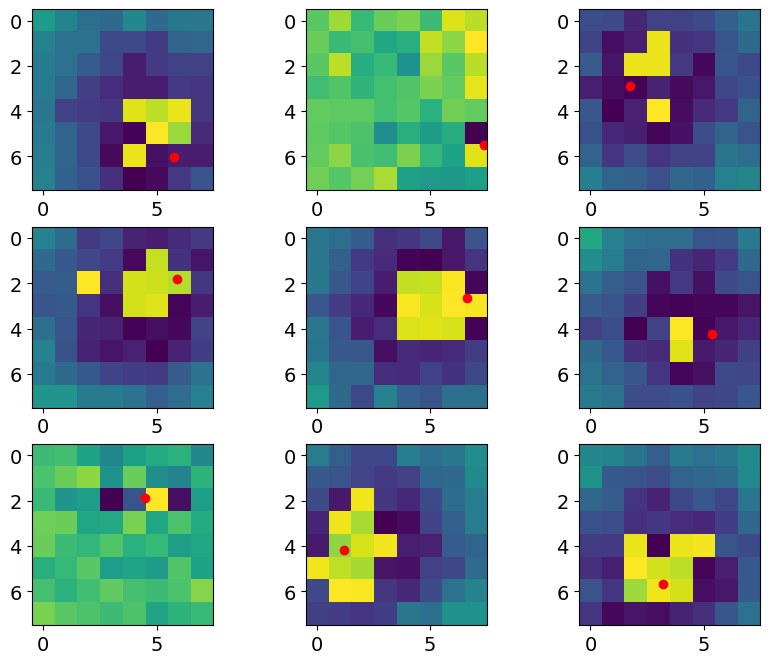

In [30]:
plot_images_and_positions(train_loader, start=10, figsize=(10, 8))

## Compare different CNNs

In [31]:
def build_cnn_l4k3322_conv_layers():
    CL = []
    c1 = Conv2dPars(in_channels=1, out_channels=64, kernel_size=3, padding=1)
    c2 = Conv2dPars(in_channels=64, out_channels=128, kernel_size=3, padding=1)
    c3 = Conv2dPars(in_channels=128, out_channels=256, kernel_size=2, padding=1)
    c4 = Conv2dPars(in_channels=256, out_channels=512, kernel_size=2, padding=1)
    p2d = MaxPool2dPars(kernel_size=2, stride=2)
    CL.append(build_conv_layer(c1, p2d, relu='leaky'))
    CL.append(build_conv_layer(c2, p2d, relu='leaky'))
    CL.append(build_conv_layer(c3, p2d, relu='leaky'))
    CL.append(build_conv_layer(c4, p2d, relu='leaky'))
    return CL, build_conv_layers(CL)

In [32]:
def build_cnn_512_3_ll(dropout_fraction=0.25):
    LLYR=[]
    LLYR.append(LinealLayerPars(512, 256))
    LLYR.append(LinealLayerPars(256, 128))
    #LLYR.append(LinealLayerPars(128, 2))
    LLYR.append(LinealLayerPars(128, 3))
    return build_linear_layers(LLYR, df=dropout_fraction)

In [217]:
def build_cnn_ll(inl=512, out=3, dropout_fraction=0.25):
    LLYR=[]
    LLYR.append(LinealLayerPars(inl,256))
    LLYR.append(LinealLayerPars(256, 128))
    #LLYR.append(LinealLayerPars(128, 2))
    LLYR.append(LinealLayerPars(128, out))
    return build_linear_layers(LLYR, df=dropout_fraction)

In [33]:
CL, clyrs = build_cnn_l4k3322_conv_layers()

In [34]:
x_cnn_evaluation(torch.randn(1,1,8,8), CL)

shape of input image = torch.Size([1, 1, 8, 8])
 after cl = 1, shape of out image = torch.Size([1, 64, 4, 4])
 after cl = 2, shape of out image = torch.Size([1, 128, 2, 2])
 after cl = 3, shape of out image = torch.Size([1, 256, 1, 1])
 after cl = 4, shape of out image = torch.Size([1, 512, 1, 1])
shape of flattened image = torch.Size([1, 512])


In [143]:
llyrs = build_cnn_512_3_ll(dropout_fraction=0.25)

In [218]:
llyrs2 = build_cnn_ll(inl=512, out=6,dropout_fraction=0.25)

In [219]:
llyrsx = build_cnn_ll(inl=512, out=2,dropout_fraction=0.25)

In [221]:
model = xCNN(clyrs,llyrs).to(device)

In [222]:
model2 = xCNN(clyrs,llyrs2).to(device)

In [223]:
modelx = xCNN(clyrs,llyrsx).to(device)

In [37]:
print(model)

xCNN(
  (conv_layer): Sequential(
    (0): Sequential(
      (0): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): LeakyReLU(negative_slope=0.01)
      (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    )
    (1): Sequential(
      (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): LeakyReLU(negative_slope=0.01)
      (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    )
    (2): Sequential(
      (0): Conv2d(128, 256, kernel_size=(2, 2), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): LeakyReLU(negative_slope=0.01)
      (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)

In [38]:
summary(model,(1,8,8))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1             [-1, 64, 8, 8]             640
       BatchNorm2d-2             [-1, 64, 8, 8]             128
         LeakyReLU-3             [-1, 64, 8, 8]               0
         MaxPool2d-4             [-1, 64, 4, 4]               0
            Conv2d-5            [-1, 128, 4, 4]          73,856
       BatchNorm2d-6            [-1, 128, 4, 4]             256
         LeakyReLU-7            [-1, 128, 4, 4]               0
         MaxPool2d-8            [-1, 128, 2, 2]               0
            Conv2d-9            [-1, 256, 3, 3]         131,328
      BatchNorm2d-10            [-1, 256, 3, 3]             512
        LeakyReLU-11            [-1, 256, 3, 3]               0
        MaxPool2d-12            [-1, 256, 1, 1]               0
           Conv2d-13            [-1, 512, 2, 2]         524,800
      BatchNorm2d-14            [-1, 51

In [39]:
optimizer = optim.Adam(model.parameters(), lr=0.001)
criterion = nn.MSELoss()

In [40]:
train_losses, val_losses = train_cnn(train_loader, val_loader, model, optimizer, device, criterion, 
                                     batch_size, epochs=10, iprnt=100)

Training with  ->213600 images
size of train loader  ->2136 images
Evaluating with  ->61100 images
size of eval loader  ->611 images
Running for epochs ->10

EPOCH 0
--- EPOCH 0 AVG TRAIN LOSS: 14.514483448941164
--- EPOCH 0 AVG VAL LOSS: 9.165981451930469

EPOCH 1
--- EPOCH 1 AVG TRAIN LOSS: 8.852175698074955
--- EPOCH 1 AVG VAL LOSS: 7.365124931116932

EPOCH 2
--- EPOCH 2 AVG TRAIN LOSS: 8.105252567525213
--- EPOCH 2 AVG VAL LOSS: 6.513324707112414

EPOCH 3
--- EPOCH 3 AVG TRAIN LOSS: 7.576130073168751
--- EPOCH 3 AVG VAL LOSS: 6.443700040420807

EPOCH 4
--- EPOCH 4 AVG TRAIN LOSS: 7.2240124978822715
--- EPOCH 4 AVG VAL LOSS: 6.528012420854084

EPOCH 5
--- EPOCH 5 AVG TRAIN LOSS: 7.017124859804518
--- EPOCH 5 AVG VAL LOSS: 6.277103297644083

EPOCH 6
--- EPOCH 6 AVG TRAIN LOSS: 6.817285465836972
--- EPOCH 6 AVG VAL LOSS: 5.867933359551937

EPOCH 7
--- EPOCH 7 AVG TRAIN LOSS: 6.644545804248767
--- EPOCH 7 AVG VAL LOSS: 6.4842427412929

EPOCH 8
--- EPOCH 8 AVG TRAIN LOSS: 6.570938493875

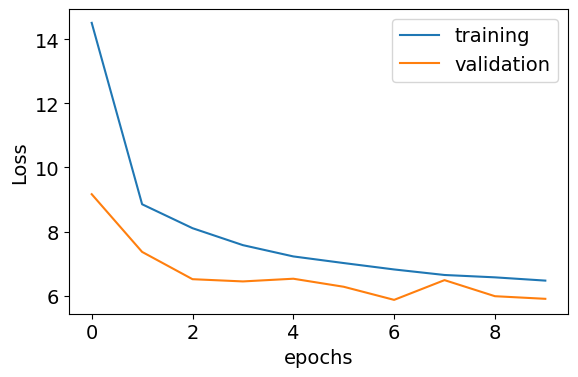

In [41]:
plot_loss(10, train_losses, val_losses,figsize=(6, 4))

In [42]:
tdeltas = evaluate_cnn(test_loader, model, device)

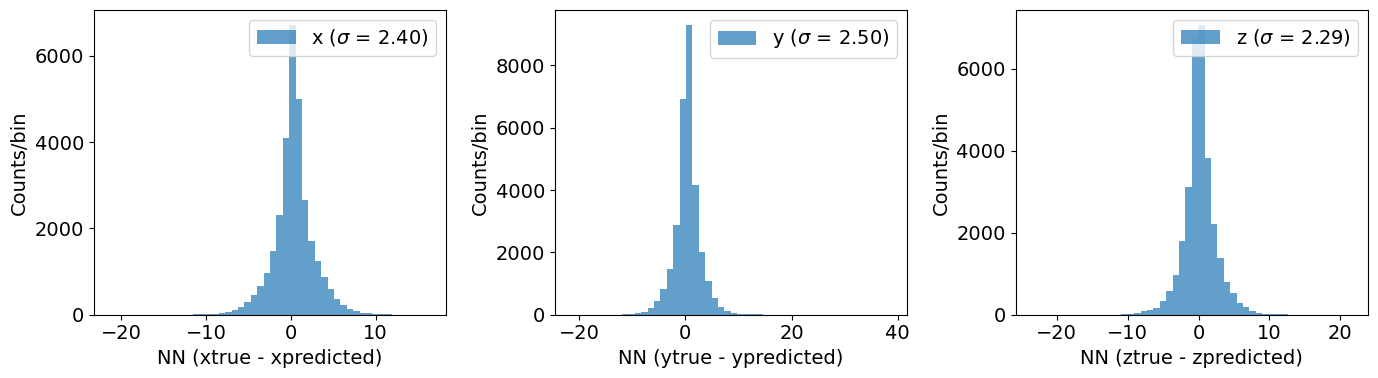

In [43]:
plotxyz(tdeltas, nbins=50)

In [44]:
f2gz, f2gx, f2gy = fit_tdeltas(tdeltas, bins=100)

2g fit: mu1 = -0.01, sigma = 0.68, n1  =0.62
2g fit: mu2 = 0.24, sigma = 2.35, n1  =0.38
weighted error: = 1.32
2g fit: mu1 = 0.35, sigma = 2.54, n1  =0.35
2g fit: mu2 = 0.29, sigma = 0.63, n1  =0.65
weighted error: = 1.29
2g fit: mu1 = 0.43, sigma = 2.57, n1  =0.34
2g fit: mu2 = 0.38, sigma = 0.74, n1  =0.66
weighted error: = 1.37


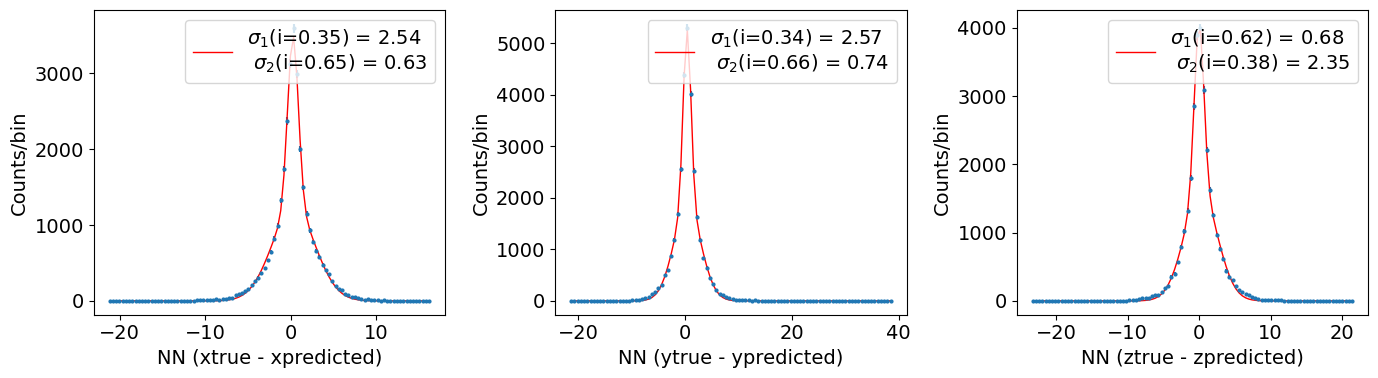

In [45]:
plotfxyz(f2gx, f2gy, f2gz, figsize=(14, 4))

In [46]:
model = CNN_basic(chi=128, dropout=False, dropout_fraction=0.2, energy=False).to(device)

In [47]:
print(model)

CNN_basic(
  (conv1): Conv2d(1, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2): Conv2d(128, 256, kernel_size=(2, 2), stride=(1, 1), padding=(1, 1))
  (bn2): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv3): Conv2d(256, 512, kernel_size=(2, 2), stride=(1, 1), padding=(1, 1))
  (bn3): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc0): Linear(in_features=512, out_features=3, bias=True)
  (drop1): Dropout(p=0.2, inplace=False)
)


In [48]:
summary(model,(1,8,8))

input data shape =>torch.Size([2, 1, 8, 8])
(8,8,1) => (4,4,128) =>torch.Size([2, 128, 4, 4])
(4,4,128) => (2,2,256) =>torch.Size([2, 256, 2, 2])
(2,2,256) => (1,1,512) =>torch.Size([2, 512, 1, 1])
(1,1,512) => (1,1,3) =>torch.Size([2, 512])
torch.Size([2, 3])
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [-1, 128, 8, 8]           1,280
       BatchNorm2d-2            [-1, 128, 8, 8]             256
         MaxPool2d-3            [-1, 128, 4, 4]               0
            Conv2d-4            [-1, 256, 5, 5]         131,328
       BatchNorm2d-5            [-1, 256, 5, 5]             512
         MaxPool2d-6            [-1, 256, 2, 2]               0
            Conv2d-7            [-1, 512, 3, 3]         524,800
       BatchNorm2d-8            [-1, 512, 3, 3]           1,024
         MaxPool2d-9            [-1, 512, 1, 1]               0
           Linear-10              

In [49]:
optimizer = optim.Adam(model.parameters(), lr=0.001)
criterion = nn.MSELoss()

In [50]:
train_losses, val_losses = train_cnn(train_loader, val_loader, model, optimizer, device, criterion, 
                                     batch_size, epochs=10, iprnt=100)

Training with  ->213600 images
size of train loader  ->2136 images
Evaluating with  ->61100 images
size of eval loader  ->611 images
Running for epochs ->10

EPOCH 0
--- EPOCH 0 AVG TRAIN LOSS: 10.991294855928599
--- EPOCH 0 AVG VAL LOSS: 8.809517964988995

EPOCH 1
--- EPOCH 1 AVG TRAIN LOSS: 7.865177978513839
--- EPOCH 1 AVG VAL LOSS: 7.429533350487192

EPOCH 2
--- EPOCH 2 AVG TRAIN LOSS: 7.2516977536990845
--- EPOCH 2 AVG VAL LOSS: 7.5693036085650105

EPOCH 3
--- EPOCH 3 AVG TRAIN LOSS: 6.929426844646868
--- EPOCH 3 AVG VAL LOSS: 6.737974814619449

EPOCH 4
--- EPOCH 4 AVG TRAIN LOSS: 6.671674970607186
--- EPOCH 4 AVG VAL LOSS: 6.841567521789851

EPOCH 5
--- EPOCH 5 AVG TRAIN LOSS: 6.492885124705704
--- EPOCH 5 AVG VAL LOSS: 6.312422032051898

EPOCH 6
--- EPOCH 6 AVG TRAIN LOSS: 6.359614486774702
--- EPOCH 6 AVG VAL LOSS: 6.484771581796499

EPOCH 7
--- EPOCH 7 AVG TRAIN LOSS: 6.2617432359006076
--- EPOCH 7 AVG VAL LOSS: 6.45949982894423

EPOCH 8
--- EPOCH 8 AVG TRAIN LOSS: 6.183922178

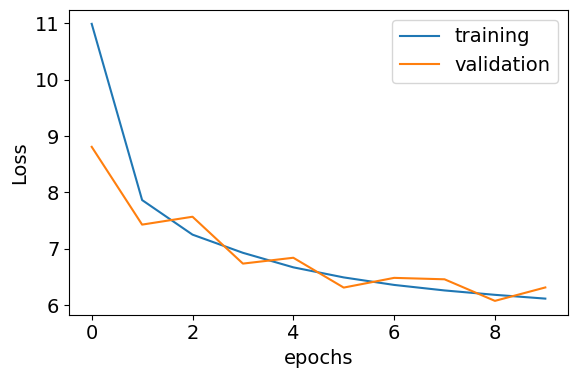

In [51]:
plot_loss(10, train_losses, val_losses,figsize=(6, 4))

In [52]:
tdeltas = evaluate_cnn(test_loader, model, device)

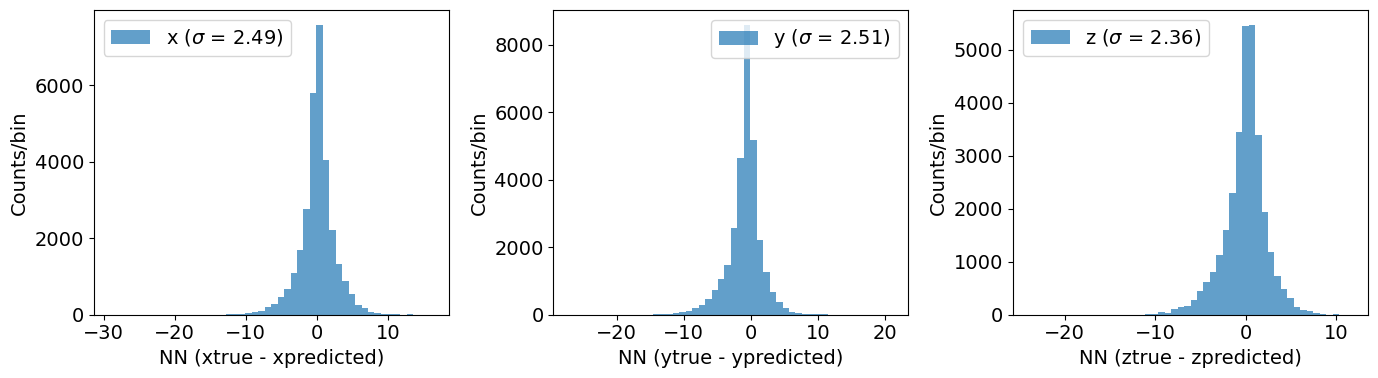

In [53]:
plotxyz(tdeltas, nbins=50)

In [54]:
f2gz, f2gx, f2gy = fit_tdeltas(tdeltas, bins=100)

2g fit: mu1 = 0.37, sigma = 0.77, n1  =0.63
2g fit: mu2 = -0.12, sigma = 2.57, n1  =0.37
weighted error: = 1.44
2g fit: mu1 = 0.19, sigma = 2.58, n1  =0.34
2g fit: mu2 = 0.17, sigma = 0.68, n1  =0.66
weighted error: = 1.33
2g fit: mu1 = -0.48, sigma = 0.67, n1  =0.68
2g fit: mu2 = -0.92, sigma = 2.57, n1  =0.32
weighted error: = 1.27


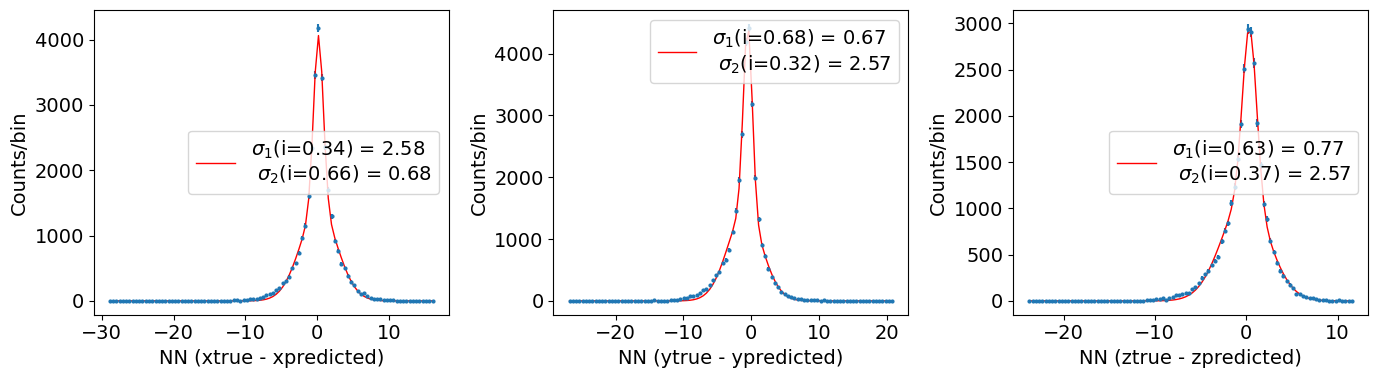

In [55]:
plotfxyz(f2gx, f2gy, f2gz, figsize=(14, 4))

### Resnet

In [57]:
model = xResNet8(ResBlock, in_channels=1, out_channels=64, num_classes = 3, 
                 dropout_fraction=0.25, debug=True, dropout=True).to(device)

 ## make_layer 1: planes = 64,  blocks = 1, stride = 1
 ## make_layer: in_planes=64
 ## make_layer: downsample = None
 ## make_layer 2: planes = 128,  blocks = 1, stride = 2
 ## make_layer: in_planes=64
 ## make_layer: downsample = Sequential(
  (0): Conv2d(64, 128, kernel_size=(1, 1), stride=(2, 2))
  (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
)
 ## make_layer 3: planes = 256,  blocks = 1, stride = 2
 ## make_layer: in_planes=128
 ## make_layer: downsample = Sequential(
  (0): Conv2d(128, 256, kernel_size=(1, 1), stride=(2, 2))
  (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
)
 ## make_layer 4: planes = 512,  blocks = 1, stride = 2
 ## make_layer: in_planes=256
 ## make_layer: downsample = Sequential(
  (0): Conv2d(256, 512, kernel_size=(1, 1), stride=(2, 2))
  (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
)


In [58]:
summary(model,(1,8,8))

  ResNet8: input data shape =>torch.Size([2, 1, 8, 8])
  ResNet8: after conv1 =>torch.Size([2, 64, 8, 8])
  ResNet8: after layer0 =>torch.Size([2, 64, 8, 8])
  ResNet8: after layer1 =>torch.Size([2, 128, 4, 4])
  ResNet8: after layer2 =>torch.Size([2, 256, 2, 2])
  ResNet8: after layer3 =>torch.Size([2, 512, 1, 1])
  ResNet8: after avgpool =>torch.Size([2, 512, 1, 1])
  ResNet8: after flatten =>torch.Size([2, 512])
  ResNet8: after fc =>torch.Size([2, 3])
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1             [-1, 64, 8, 8]             640
       BatchNorm2d-2             [-1, 64, 8, 8]             128
              ReLU-3             [-1, 64, 8, 8]               0
            Conv2d-4             [-1, 64, 8, 8]          36,928
       BatchNorm2d-5             [-1, 64, 8, 8]             128
              ReLU-6             [-1, 64, 8, 8]               0
            Conv2d-7       

In [59]:
optimizer = optim.Adam(model.parameters(), lr=0.001)
criterion = nn.MSELoss()

In [60]:
train_losses, val_losses = train_cnn(train_loader, val_loader, model, optimizer, device, criterion, 
                                     batch_size, epochs=10, iprnt=100)

Training with  ->213600 images
size of train loader  ->2136 images
Evaluating with  ->61100 images
size of eval loader  ->611 images
Running for epochs ->10

EPOCH 0
--- EPOCH 0 AVG TRAIN LOSS: 13.577583501178227
--- EPOCH 0 AVG VAL LOSS: 7.094137507842918

EPOCH 1
--- EPOCH 1 AVG TRAIN LOSS: 8.457337674576692
--- EPOCH 1 AVG VAL LOSS: 7.10324300915832

EPOCH 2
--- EPOCH 2 AVG TRAIN LOSS: 7.780587507990862
--- EPOCH 2 AVG VAL LOSS: 6.620786246223262

EPOCH 3
--- EPOCH 3 AVG TRAIN LOSS: 7.382715749829896
--- EPOCH 3 AVG VAL LOSS: 7.146875013891492

EPOCH 4
--- EPOCH 4 AVG TRAIN LOSS: 7.143728915225254
--- EPOCH 4 AVG VAL LOSS: 6.002776664134523

EPOCH 5
--- EPOCH 5 AVG TRAIN LOSS: 6.9142518561431086
--- EPOCH 5 AVG VAL LOSS: 7.878908896407207

EPOCH 6
--- EPOCH 6 AVG TRAIN LOSS: 6.79916190855512
--- EPOCH 6 AVG VAL LOSS: 5.93274720522854

EPOCH 7
--- EPOCH 7 AVG TRAIN LOSS: 6.6667107098111495
--- EPOCH 7 AVG VAL LOSS: 10.767210409411042

EPOCH 8
--- EPOCH 8 AVG TRAIN LOSS: 6.56271071000

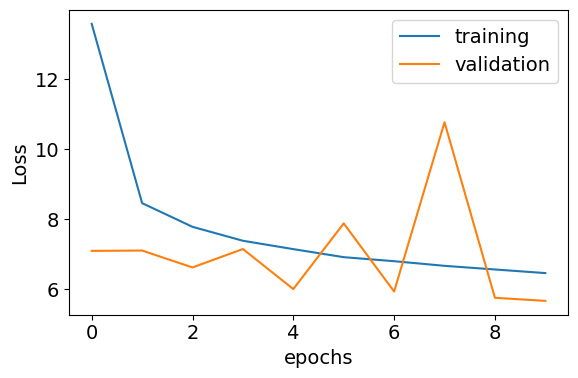

In [61]:
plot_loss(10, train_losses, val_losses,figsize=(6, 4))

In [62]:
tdeltas = evaluate_cnn(test_loader, model, device)

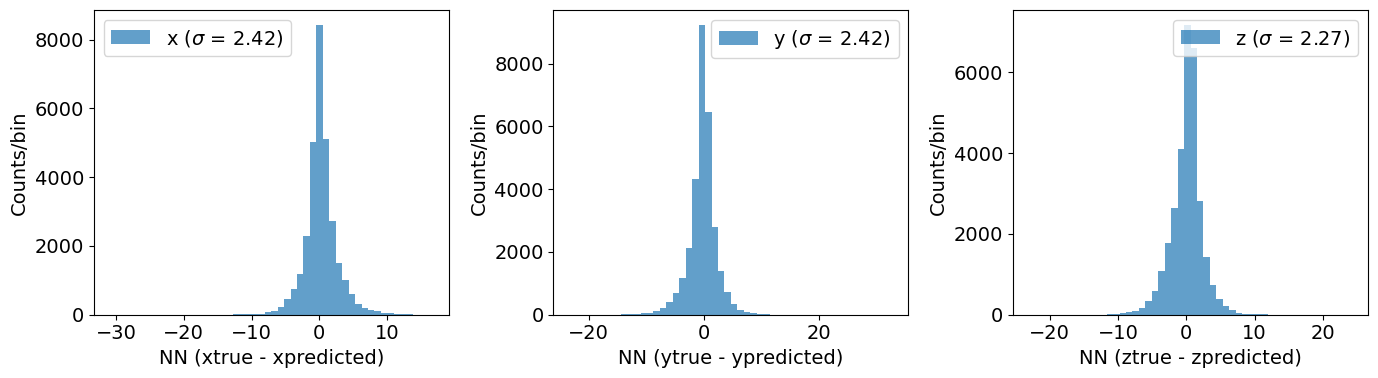

In [63]:
plotxyz(tdeltas, nbins=50)

In [64]:
f2gz, f2gx, f2gy = fit_tdeltas(tdeltas, bins=100)

2g fit: mu1 = -0.14, sigma = 2.40, n1  =0.39
2g fit: mu2 = 0.57, sigma = 0.72, n1  =0.61
weighted error: = 1.37
2g fit: mu1 = 0.33, sigma = 2.39, n1  =0.36
2g fit: mu2 = 0.01, sigma = 0.69, n1  =0.64
weighted error: = 1.29
2g fit: mu1 = -0.14, sigma = 2.40, n1  =0.37
2g fit: mu2 = -0.04, sigma = 0.70, n1  =0.63
weighted error: = 1.33


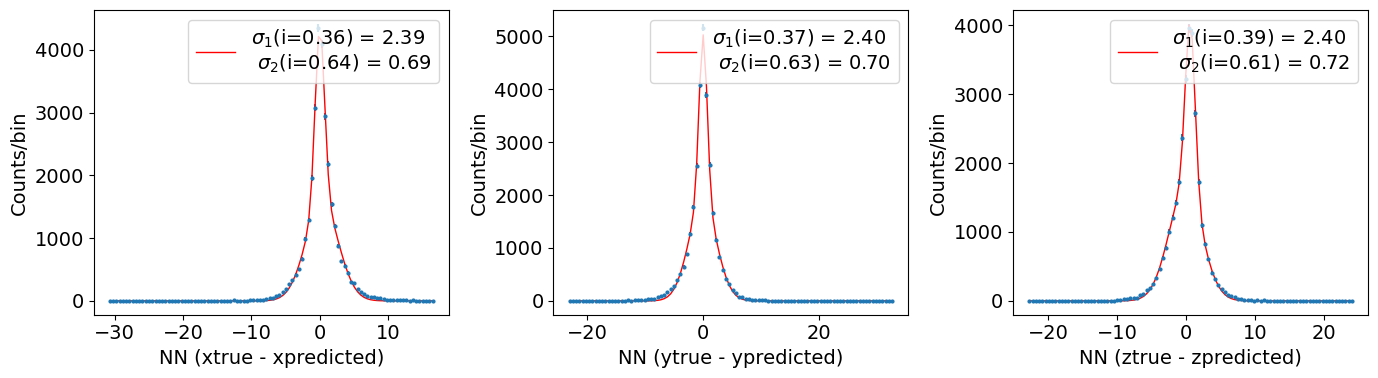

In [65]:
plotfxyz(f2gx, f2gy, f2gz, figsize=(14, 4))

## CNN comparison- Weighted error:
- Resnet:(1.37, 1.29, 1.33)
- Basic: (1.44, 1.33, 1.27)
- Dense: (1.32, 1.29, 1.37)

## Normalization

files in dir: 100
shape -> (3027, 8, 8)
mean img0 =205.46875
std  img0 =33.66422653198242


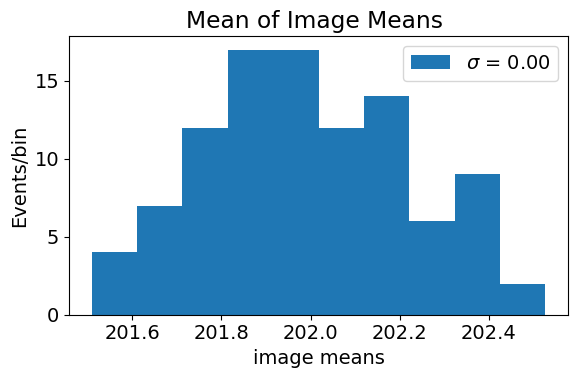

In [66]:
means, stds = get_means_stds2(dir=d1c)
meansx =[np.mean(x) for x in means]
imean = np.mean(meansx)
histoplot(meansx, "image means", vart="Mean of Image Means ", num_bins = 10, figsize=(6, 4))


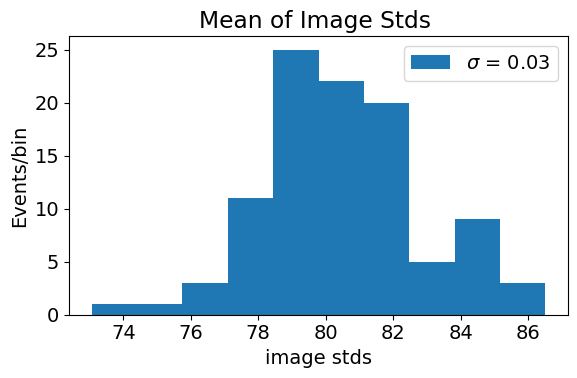

In [67]:
stdsx =[np.std(x) for x in stds]
isigma = np.mean(stdsx)
histoplot(stdsx, "image stds", vart="Mean of Image Stds ", num_bins = 10, figsize=(6, 4))


In [68]:
print(f"Normalization: mean = {imean}, std = {isigma}")

Normalization: mean = 201.99266052246094, std = 80.52242279052734


In [72]:
dataset = RDataset(dir_root, first_file, last_file,type="1c", norm=True, mean=imean, std=isigma)  

Running rDataset with norm = True
Loading files in directory d1c with indexes: 0, 100
   event_id         e          x          y          z         t
0     10004  0.510118  18.645067  12.477487  29.249544  0.116340
1     10006  0.509274  13.566376   1.647984  21.156849  0.090734
2     10014  0.509922  -5.014233   5.060986  12.715019  0.062352
3     10018  0.508170 -22.957691  -9.322307  45.483715  0.171746
4     10024  0.508948  -3.514938  -0.639491  15.746504  0.074194
5     10026  0.508879  18.973616  -6.031100  16.421364  0.074508
6     10027  0.508849  11.437413 -22.155209  40.912632  0.157729
7     10028  0.509717   9.708068   3.101630  13.316263  0.064982
8     10029  0.509517   0.335767 -11.193620  21.898740  0.093051
9     10030  0.509092  16.716444  15.401320  25.922293  0.107143
image name = images_1.npy
image number = 1
number of images in file = 3032
number of labels in file = 3032
meta =>[1.00040000e+04 5.10118200e-01 1.86450670e+01 1.24774870e+01
 2.92495440e+01 1.163400

In [73]:
data_loader, train_loader, val_loader, test_loader = mono_data_loader(dataset, 
                                                                      batch_size=batch_size, 
                                                                      train_fraction=train_fraction, 
                                                                      val_fraction=val_fraction)

Loaded 305080 events
 train size = 213556
 val size = 61016
 test size = 30508
 train indices = range(0, 213556)
 val indices = range(213556, 274572)
 test indices = range(274572, 305080)
213556 training events (70.0%)
61016 validation events (20.0%)
30508 test events (10.0%)


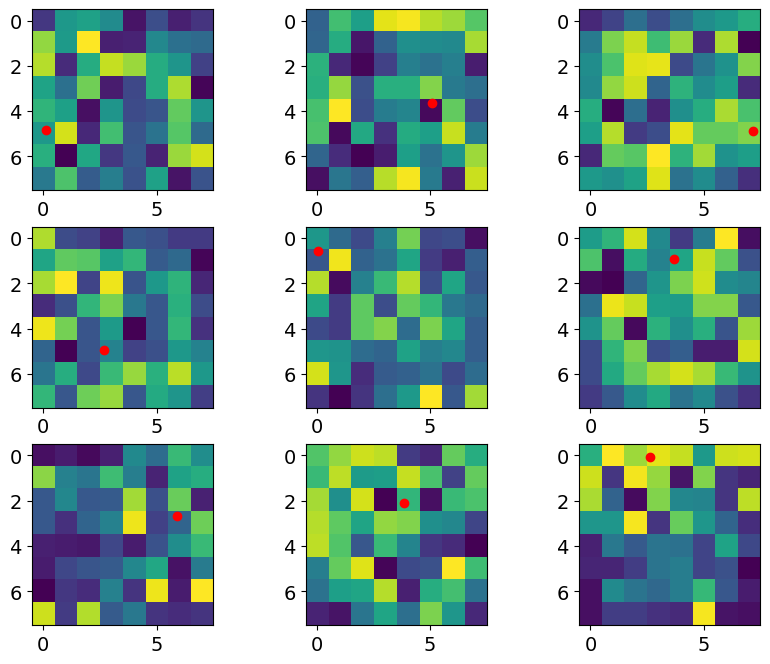

In [74]:
plot_images_and_positions(train_loader, start=0, figsize=(10, 8))

In [75]:
model = CNN_basic(chi=128, dropout=False, dropout_fraction=0.2, energy=False).to(device)
optimizer = optim.Adam(model.parameters(), lr=0.001)
criterion = nn.MSELoss()

In [76]:
train_losses, val_losses = train_cnn(train_loader, val_loader, model, optimizer, device, criterion, 
                                     batch_size, epochs=10, iprnt=100)

Training with  ->213600 images
size of train loader  ->2136 images
Evaluating with  ->61100 images
size of eval loader  ->611 images
Running for epochs ->10

EPOCH 0
input data shape =>torch.Size([100, 1, 8, 8])
(8,8,1) => (4,4,128) =>torch.Size([100, 128, 4, 4])
(4,4,128) => (2,2,256) =>torch.Size([100, 256, 2, 2])
(2,2,256) => (1,1,512) =>torch.Size([100, 512, 1, 1])
(1,1,512) => (1,1,3) =>torch.Size([100, 512])
torch.Size([100, 3])
--- EPOCH 0 AVG TRAIN LOSS: 10.56619693076566
--- EPOCH 0 AVG VAL LOSS: 7.987740068701012

EPOCH 1
--- EPOCH 1 AVG TRAIN LOSS: 7.36639330896099
--- EPOCH 1 AVG VAL LOSS: 6.993080409966202

EPOCH 2
--- EPOCH 2 AVG TRAIN LOSS: 6.877166949407885
--- EPOCH 2 AVG VAL LOSS: 6.576847029590763

EPOCH 3
--- EPOCH 3 AVG TRAIN LOSS: 6.593889815195669
--- EPOCH 3 AVG VAL LOSS: 6.574053614502453

EPOCH 4
--- EPOCH 4 AVG TRAIN LOSS: 6.399337303549163
--- EPOCH 4 AVG VAL LOSS: 6.60734534458716

EPOCH 5
--- EPOCH 5 AVG TRAIN LOSS: 6.231981711776069
--- EPOCH 5 AVG VAL LO

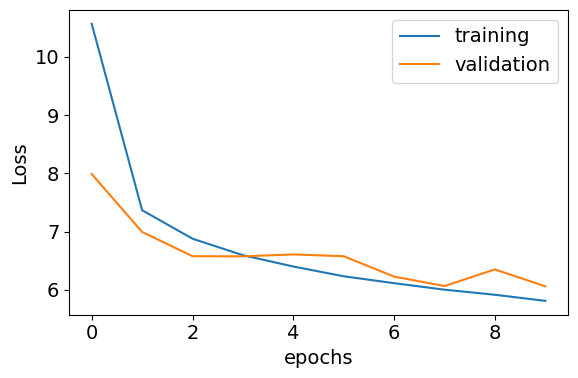

In [77]:
plot_loss(10, train_losses, val_losses,figsize=(6, 4))

In [78]:
tdeltas = evaluate_cnn(test_loader, model, device)

2g fit: mu1 = 0.59, sigma = 0.68, n1  =0.65
2g fit: mu2 = 0.12, sigma = 2.49, n1  =0.35
weighted error: = 1.31
2g fit: mu1 = -0.06, sigma = 0.80, n1  =0.68
2g fit: mu2 = 0.11, sigma = 2.71, n1  =0.32
weighted error: = 1.41
2g fit: mu1 = -0.64, sigma = 0.82, n1  =0.65
2g fit: mu2 = -0.34, sigma = 2.71, n1  =0.35
weighted error: = 1.48


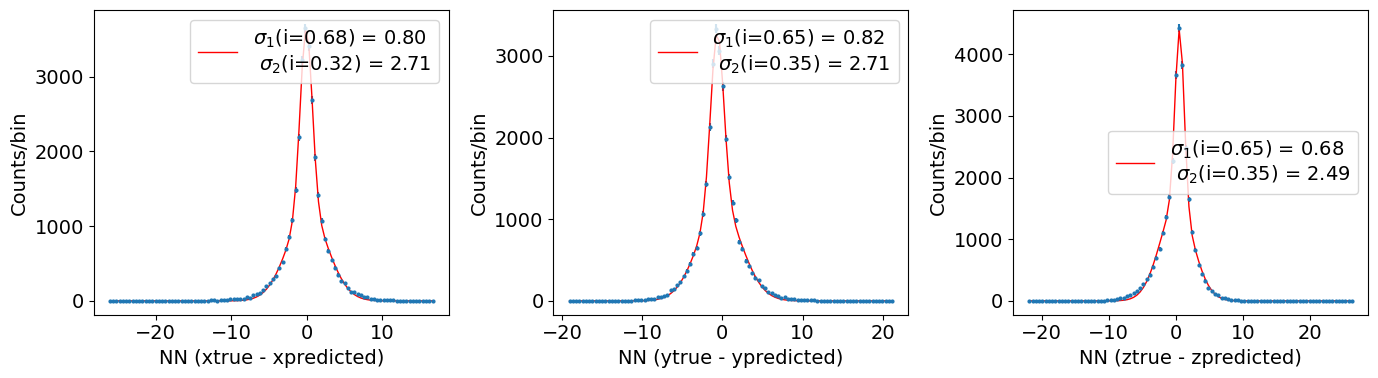

In [79]:
f2gz, f2gx, f2gy = fit_tdeltas(tdeltas, bins=100)
plotfxyz(f2gx, f2gy, f2gz, figsize=(14, 4))

#### No advantage in normalization for CNN basic

In [81]:
model = xCNN(clyrs,llyrs).to(device)
optimizer = optim.Adam(model.parameters(), lr=0.001)
criterion = nn.MSELoss()

In [82]:
train_losses, val_losses = train_cnn(train_loader, val_loader, model, optimizer, device, criterion, 
                                     batch_size, epochs=10, iprnt=100)

Training with  ->213600 images
size of train loader  ->2136 images
Evaluating with  ->61100 images
size of eval loader  ->611 images
Running for epochs ->10

EPOCH 0
--- EPOCH 0 AVG TRAIN LOSS: 7.063806285572409
--- EPOCH 0 AVG VAL LOSS: 6.579410525663785

EPOCH 1
--- EPOCH 1 AVG TRAIN LOSS: 6.647277168566815
--- EPOCH 1 AVG VAL LOSS: 6.348980011994632

EPOCH 2
--- EPOCH 2 AVG TRAIN LOSS: 6.464282497484586
--- EPOCH 2 AVG VAL LOSS: 6.088807905169048

EPOCH 3
--- EPOCH 3 AVG TRAIN LOSS: 6.343332908573222
--- EPOCH 3 AVG VAL LOSS: 5.874922168235342

EPOCH 4
--- EPOCH 4 AVG TRAIN LOSS: 6.2263924168067035
--- EPOCH 4 AVG VAL LOSS: 5.941581513019318

EPOCH 5
--- EPOCH 5 AVG TRAIN LOSS: 6.136762535304166
--- EPOCH 5 AVG VAL LOSS: 5.864608915269668

EPOCH 6
--- EPOCH 6 AVG TRAIN LOSS: 6.056179945723394
--- EPOCH 6 AVG VAL LOSS: 6.2434913932594265

EPOCH 7
--- EPOCH 7 AVG TRAIN LOSS: 5.958977881442295
--- EPOCH 7 AVG VAL LOSS: 5.798707018897498

EPOCH 8
--- EPOCH 8 AVG TRAIN LOSS: 5.9314478457

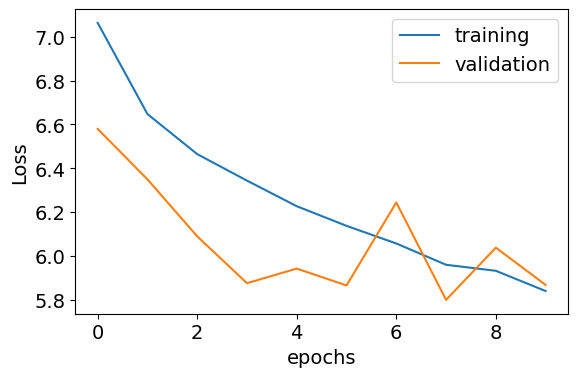

In [83]:
plot_loss(10, train_losses, val_losses,figsize=(6, 4))

2g fit: mu1 = -1.00, sigma = 8.78, n1  =0.09
2g fit: mu2 = 1.00, sigma = 3.69, n1  =0.91
weighted error: = 4.15
2g fit: mu1 = 0.58, sigma = 1.66, n1  =0.51
2g fit: mu2 = -0.39, sigma = 4.05, n1  =0.49
weighted error: = 2.83
2g fit: mu1 = -0.10, sigma = 4.00, n1  =0.57
2g fit: mu2 = 0.60, sigma = 1.50, n1  =0.43
weighted error: = 2.93


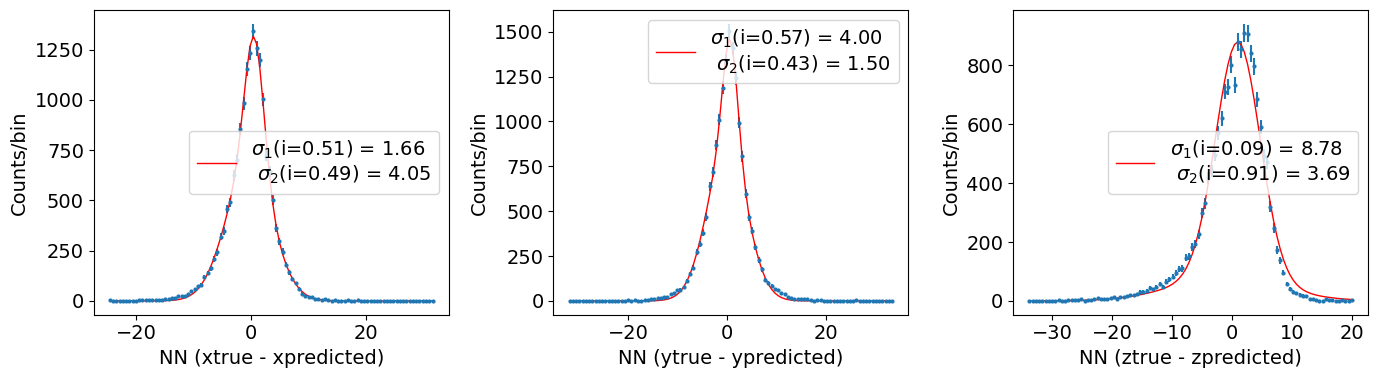

In [131]:
tdeltas = evaluate_cnn(test_loader, model, device)
f2gz, f2gx, f2gy = fit_tdeltas(tdeltas, bins=100)
plotfxyz(f2gx, f2gy, f2gz, figsize=(14, 4))

### Slightly better performance with dense layer 

## Case of 2c

In [90]:
img_names, csv_name = get_file_names_format1(d2c)
df2c = pd.read_csv(csv_name[0])
df2c.head(10)

,event_id,e1,x1,y1,z1,t1,e2,x2,y2,z2,t2,etot
0,10001,0.116762,-2.954058,-18.557474,22.369658,0.094753,0.391388,-5.125206,-7.548854,28.827255,0.137937,0.508150
1,10003,0.330298,4.990295,0.311470,16.939790,0.091601,0.179934,11.767439,1.126573,13.503364,0.066109,0.510232
2,10009,0.322141,9.770208,10.759822,43.035156,0.164733,0.186507,12.210072,15.519191,37.142850,0.191277,0.508648
3,10013,0.265549,6.276037,13.364479,40.609715,0.156441,0.244618,21.409986,-10.269456,37.568260,0.250601,0.510166
4,10017,0.178680,10.950835,11.677908,17.862885,0.091082,0.329565,13.083003,7.918981,15.518206,0.072993,0.508245
5,10019,0.130845,3.697574,-9.119902,20.059360,0.088333,0.378074,4.120632,-2.767935,25.876673,0.117098,0.508920
6,10021,0.199376,17.825558,9.695036,39.495113,0.172827,0.310208,17.672928,13.185935,41.431313,0.159502,0.509583
7,10022,0.227905,-2.110336,3.168093,16.415188,0.131357,0.281414,1.825020,19.210318,16.948578,0.076230,0.509320
8,10041,0.222565,-16.442682,3.667482,34.749690,0.253564,0.286785,2.083207,23.206896,41.997800,0.160552,0.509350
9,10052,0.213205,-7.519110,9.087627,23.318674,0.098959,0.295847,2.618013,13.270862,27.253040,0.137822,0.509052


In [91]:
imgs, imgf_path, imgf_name, imfn = get_image_file_data(img_names,img_file_index=0)
print(f"image file path = {imgf_path}")
print(f"image file name = {imgf_name}")
print(f"image file number = {imfn}")
print(f"number of images in file = {len(imgs)}")



image file path = /home/investigator/Data/monolithic_csi/CsI_6x6_fullwrap_50k_0MHzDC_PTFE_LUT_gamma_vox_12mm/df2c/images_1.npy
image file name = images_1.npy
image file number = 1
number of images in file = 1679


In [96]:
df2cs = get_img_file_metadata(df2c, imfn)  # This are the events corresponding to the images
print(f"number of labels in file = {len(df2cs)}")

number of labels in file = 1679


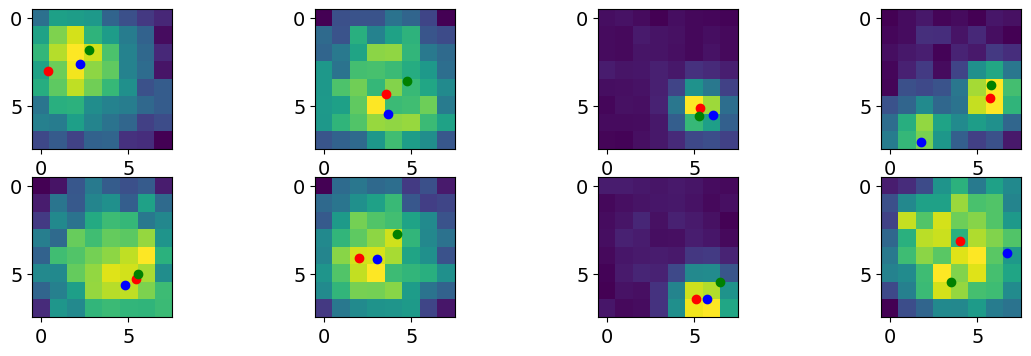

In [102]:
plot_images2c(imgs, df2cs, (0,8), pixel_size = 6, grid_size=8)

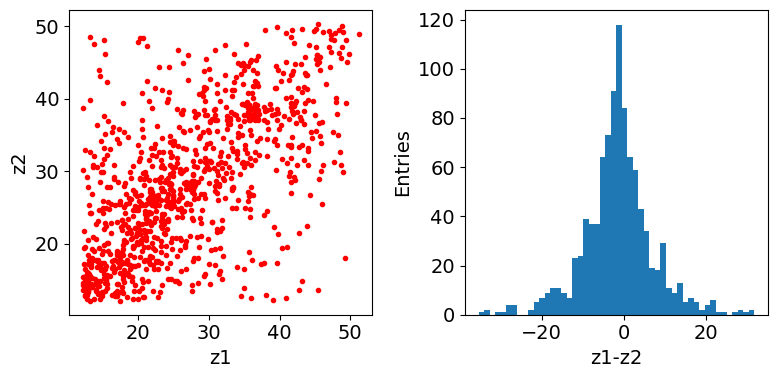

In [124]:
plot2c_z(df2cs, (0,1000),figsize=(8, 4))

In [125]:
dataset = RDataset(dir_root, first_file, last_file,type="2c", norm=False) 

Running rDataset with norm = False
Loading files in directory d2c with indexes: 0, 100
   event_id        e1         x1         y1         z1        t1        e2  \
0     10001  0.116762  -2.954058 -18.557474  22.369658  0.094753  0.391388   
1     10003  0.330298   4.990295   0.311470  16.939790  0.091601  0.179934   
2     10009  0.322141   9.770208  10.759822  43.035156  0.164733  0.186507   
3     10013  0.265549   6.276037  13.364479  40.609715  0.156441  0.244618   
4     10017  0.178680  10.950835  11.677908  17.862885  0.091082  0.329565   
5     10019  0.130845   3.697574  -9.119902  20.059360  0.088333  0.378074   
6     10021  0.199376  17.825558   9.695036  39.495113  0.172827  0.310208   
7     10022  0.227905  -2.110336   3.168093  16.415188  0.131357  0.281414   
8     10041  0.222565 -16.442682   3.667482  34.749690  0.253564  0.286785   
9     10052  0.213205  -7.519110   9.087627  23.318674  0.098959  0.295847   

          x2         y2         z2        t2      etot

In [126]:
dataset[0]

(tensor([[[189., 225., 223., 220., 180., 166., 152., 142.],
          [226., 268., 291., 240., 222., 198., 179., 128.],
          [242., 283., 303., 290., 252., 202., 183., 143.],
          [226., 262., 300., 272., 259., 202., 186., 132.],
          [235., 258., 286., 264., 243., 213., 167., 175.],
          [192., 236., 238., 211., 202., 199., 183., 175.],
          [201., 198., 224., 204., 191., 182., 156., 164.],
          [161., 174., 158., 179., 181., 148., 146., 122.]]]),
 tensor([ -2.9541, -18.5575,  22.3697]))

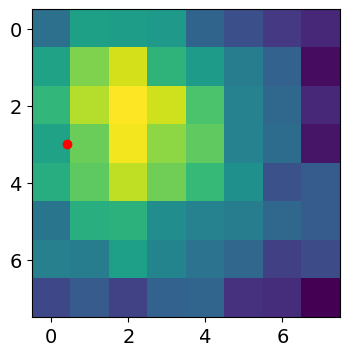

In [127]:
plot_dataset(dataset[0], pixel_size = 6, grid_size=8)

In [128]:
data_loader, train_loader, val_loader, test_loader = mono_data_loader(dataset, 
                                                                      batch_size=batch_size, 
                                                                      train_fraction=train_fraction, 
                                                                      val_fraction=val_fraction)

Loaded 167672 events
 train size = 117370
 val size = 33534
 test size = 16768
 train indices = range(0, 117370)
 val indices = range(117370, 150904)
 test indices = range(150904, 167672)
117370 training events (69.99976143899995%)
33534 validation events (19.99976143899995%)
16768 test events (10.000477122000095%)


In [129]:
model = xCNN(clyrs,llyrs).to(device)
optimizer = optim.Adam(model.parameters(), lr=0.001)
criterion = nn.MSELoss()

In [130]:
train_losses, val_losses = train_cnn(train_loader, val_loader, model, optimizer, device, criterion, 
                                     batch_size, epochs=10, iprnt=100)

Training with  ->117400 images
size of train loader  ->1174 images
Evaluating with  ->33600 images
size of eval loader  ->336 images
Running for epochs ->10

EPOCH 0
--- EPOCH 0 AVG TRAIN LOSS: 22.8550000166365
--- EPOCH 0 AVG VAL LOSS: 21.551488098644075

EPOCH 1
--- EPOCH 1 AVG TRAIN LOSS: 21.001068609942774
--- EPOCH 1 AVG VAL LOSS: 20.396758956568583

EPOCH 2
--- EPOCH 2 AVG TRAIN LOSS: 20.342600176647128
--- EPOCH 2 AVG VAL LOSS: 19.899358672755106

EPOCH 3
--- EPOCH 3 AVG TRAIN LOSS: 19.98355076138368
--- EPOCH 3 AVG VAL LOSS: 19.6011896161806

EPOCH 4
--- EPOCH 4 AVG TRAIN LOSS: 19.713840507364353
--- EPOCH 4 AVG VAL LOSS: 19.158693032605306

EPOCH 5
--- EPOCH 5 AVG TRAIN LOSS: 19.47232090919144
--- EPOCH 5 AVG VAL LOSS: 19.110943320251646

EPOCH 6
--- EPOCH 6 AVG TRAIN LOSS: 19.297208249061235
--- EPOCH 6 AVG VAL LOSS: 19.470106255440484

EPOCH 7
--- EPOCH 7 AVG TRAIN LOSS: 19.051731468668585
--- EPOCH 7 AVG VAL LOSS: 18.86606577180681

EPOCH 8
--- EPOCH 8 AVG TRAIN LOSS: 18.92

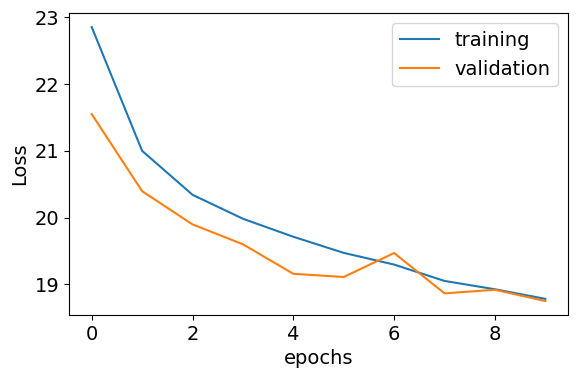

In [132]:
plot_loss(10, train_losses, val_losses,figsize=(6, 4))

2g fit: mu1 = -1.00, sigma = 8.78, n1  =0.09
2g fit: mu2 = 1.00, sigma = 3.69, n1  =0.91
weighted error: = 4.15
2g fit: mu1 = 0.58, sigma = 1.66, n1  =0.51
2g fit: mu2 = -0.39, sigma = 4.05, n1  =0.49
weighted error: = 2.83
2g fit: mu1 = -0.10, sigma = 4.00, n1  =0.57
2g fit: mu2 = 0.60, sigma = 1.50, n1  =0.43
weighted error: = 2.93


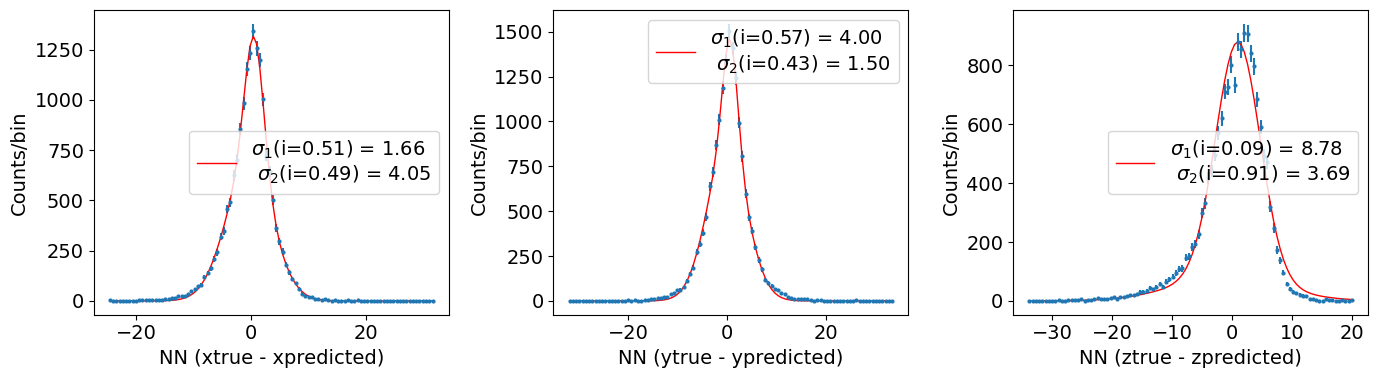

In [133]:
tdeltas = evaluate_cnn(test_loader, model, device)
f2gz, f2gx, f2gy = fit_tdeltas(tdeltas, bins=100)
plotfxyz(f2gx, f2gy, f2gz, figsize=(14, 4))

In [192]:
model2 = xCNN(clyrs,llyrs2).to(device)

In [193]:
summary(model2,(1,8,8))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1             [-1, 64, 8, 8]             640
       BatchNorm2d-2             [-1, 64, 8, 8]             128
         LeakyReLU-3             [-1, 64, 8, 8]               0
         MaxPool2d-4             [-1, 64, 4, 4]               0
            Conv2d-5            [-1, 128, 4, 4]          73,856
       BatchNorm2d-6            [-1, 128, 4, 4]             256
         LeakyReLU-7            [-1, 128, 4, 4]               0
         MaxPool2d-8            [-1, 128, 2, 2]               0
            Conv2d-9            [-1, 256, 3, 3]         131,328
      BatchNorm2d-10            [-1, 256, 3, 3]             512
        LeakyReLU-11            [-1, 256, 3, 3]               0
        MaxPool2d-12            [-1, 256, 1, 1]               0
           Conv2d-13            [-1, 512, 2, 2]         524,800
      BatchNorm2d-14            [-1, 51

In [194]:
optimizer = optim.Adam(model2.parameters(), lr=0.001)
criterion = nn.MSELoss()

In [156]:
dataset2 = R2Dataset(dir_root, first_file, last_file, norm=False) 

Running rDataset with norm = False
Loading files in directory d2c with indexes: 0, 100
   event_id        e1         x1         y1         z1        t1        e2  \
0     10001  0.116762  -2.954058 -18.557474  22.369658  0.094753  0.391388   
1     10003  0.330298   4.990295   0.311470  16.939790  0.091601  0.179934   
2     10009  0.322141   9.770208  10.759822  43.035156  0.164733  0.186507   
3     10013  0.265549   6.276037  13.364479  40.609715  0.156441  0.244618   
4     10017  0.178680  10.950835  11.677908  17.862885  0.091082  0.329565   
5     10019  0.130845   3.697574  -9.119902  20.059360  0.088333  0.378074   
6     10021  0.199376  17.825558   9.695036  39.495113  0.172827  0.310208   
7     10022  0.227905  -2.110336   3.168093  16.415188  0.131357  0.281414   
8     10041  0.222565 -16.442682   3.667482  34.749690  0.253564  0.286785   
9     10052  0.213205  -7.519110   9.087627  23.318674  0.098959  0.295847   

          x2         y2         z2        t2      etot

In [158]:
dataset2[0]

(tensor([[[189., 225., 223., 220., 180., 166., 152., 142.],
          [226., 268., 291., 240., 222., 198., 179., 128.],
          [242., 283., 303., 290., 252., 202., 183., 143.],
          [226., 262., 300., 272., 259., 202., 186., 132.],
          [235., 258., 286., 264., 243., 213., 167., 175.],
          [192., 236., 238., 211., 202., 199., 183., 175.],
          [201., 198., 224., 204., 191., 182., 156., 164.],
          [161., 174., 158., 179., 181., 148., 146., 122.]]]),
 tensor([ -2.9541, -18.5575,  22.3697,  -5.1252,  -7.5489,  28.8273]))

In [159]:
data_loader, train_loader, val_loader, test_loader = mono_data_loader(dataset2, 
                                                                      batch_size=batch_size, 
                                                                      train_fraction=train_fraction, 
                                                                      val_fraction=val_fraction)

Loaded 167672 events
 train size = 117370
 val size = 33534
 test size = 16768
 train indices = range(0, 117370)
 val indices = range(117370, 150904)
 test indices = range(150904, 167672)
117370 training events (69.99976143899995%)
33534 validation events (19.99976143899995%)
16768 test events (10.000477122000095%)


In [195]:
train_losses, val_losses = train_cnn(train_loader, val_loader, model2, optimizer, device, criterion, 
                                     batch_size, epochs=20, iprnt=100)

Training with  ->117400 images
size of train loader  ->1174 images
Evaluating with  ->33600 images
size of eval loader  ->336 images
Running for epochs ->20

EPOCH 0
--- EPOCH 0 AVG TRAIN LOSS: 20.925625795400123
--- EPOCH 0 AVG VAL LOSS: 20.218810254619235

EPOCH 1
--- EPOCH 1 AVG TRAIN LOSS: 19.635121882469527
--- EPOCH 1 AVG VAL LOSS: 19.155927220980328

EPOCH 2
--- EPOCH 2 AVG TRAIN LOSS: 19.240666233498153
--- EPOCH 2 AVG VAL LOSS: 17.991411217621394

EPOCH 3
--- EPOCH 3 AVG TRAIN LOSS: 18.931089803348
--- EPOCH 3 AVG VAL LOSS: 18.36806664296559

EPOCH 4
--- EPOCH 4 AVG TRAIN LOSS: 18.802969749782115
--- EPOCH 4 AVG VAL LOSS: 17.93714916989917

EPOCH 5
--- EPOCH 5 AVG TRAIN LOSS: 18.610806078480294
--- EPOCH 5 AVG VAL LOSS: 18.192496955394745

EPOCH 6
--- EPOCH 6 AVG TRAIN LOSS: 18.475024822826484
--- EPOCH 6 AVG VAL LOSS: 18.037459174791973

EPOCH 7
--- EPOCH 7 AVG TRAIN LOSS: 18.450558993032477
--- EPOCH 7 AVG VAL LOSS: 17.880076062111627

EPOCH 8
--- EPOCH 8 AVG TRAIN LOSS: 18.

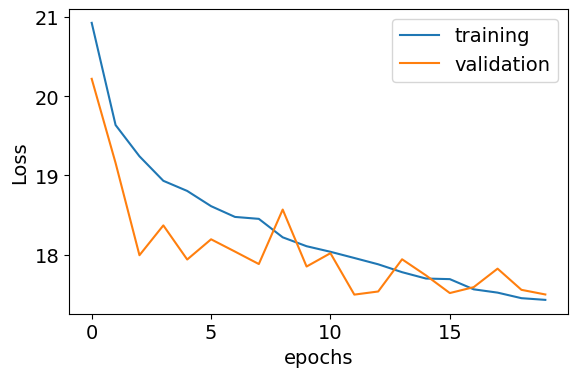

In [196]:
plot_loss(20, train_losses, val_losses,figsize=(6, 4))

In [197]:
td12 =evaluate_2c_cnn(test_loader, model2, device)
   


In [198]:
delta_x1 = td12.true_x1 - td12.pred_x1
delta_y1 = td12.true_y1 - td12.pred_y1
delta_z1 = td12.true_z1 - td12.pred_z1
tdeltas = namedtuple('tdeltas','delta_x_NN, delta_y_NN, delta_z_NN')

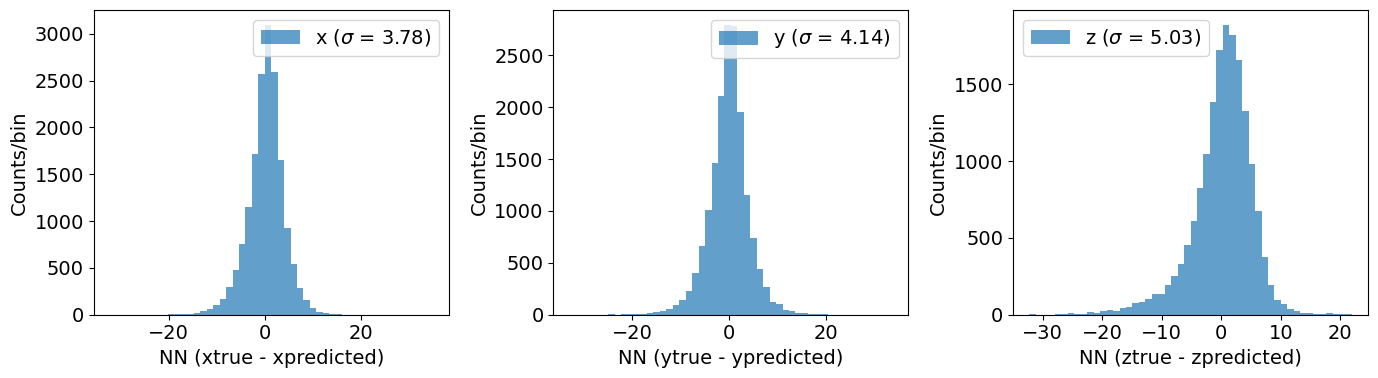

In [199]:
plotxyz(tdeltas(delta_x1, delta_y1, delta_z1), nbins=50)

2g fit: mu1 = 1.00, sigma = 3.25, n1  =0.87
2g fit: mu2 = -1.00, sigma = 7.91, n1  =0.13
weighted error: = 3.87
2g fit: mu1 = -0.02, sigma = 4.13, n1  =0.46
2g fit: mu2 = 0.79, sigma = 1.70, n1  =0.54
weighted error: = 2.82
2g fit: mu1 = -0.28, sigma = 4.17, n1  =0.52
2g fit: mu2 = 0.36, sigma = 1.63, n1  =0.48
weighted error: = 2.96


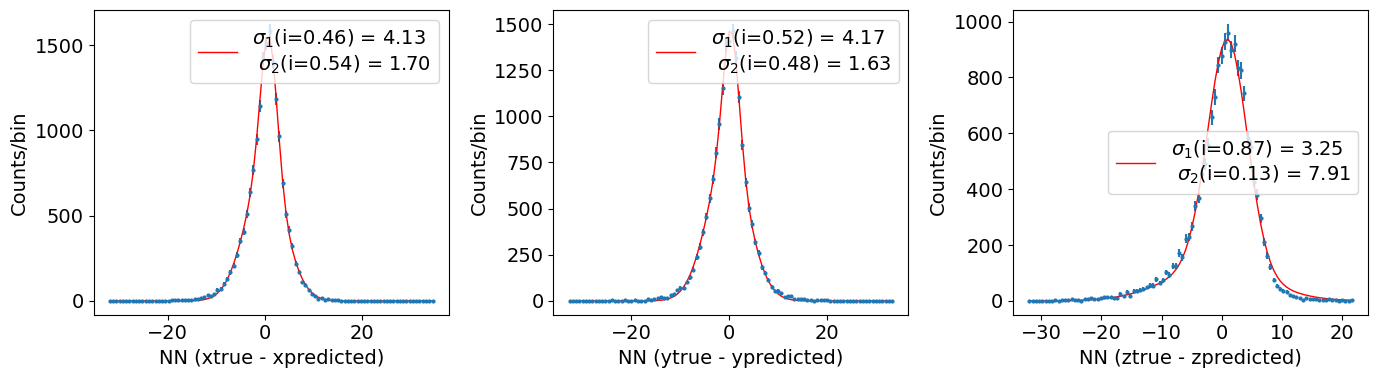

In [202]:
f2gz, f2gx, f2gy = fit_tdeltas(tdeltas(delta_x1, delta_y1, delta_z1), bins=100)
plotfxyz(f2gx, f2gy, f2gz, figsize=(14, 4))

In [203]:
delta_x2 = td12.true_x2 - td12.pred_x2
delta_y2 = td12.true_y2 - td12.pred_y2
delta_z2 = td12.true_z2 - td12.pred_z2

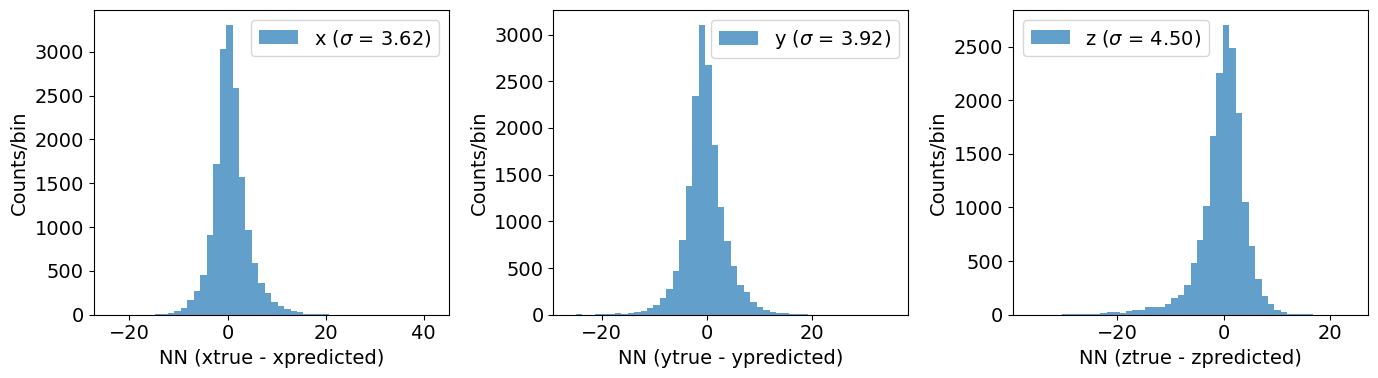

In [204]:
plotxyz(tdeltas(delta_x2, delta_y2, delta_z2), nbins=50)

2g fit: mu1 = 0.74, sigma = 2.21, n1  =0.74
2g fit: mu2 = -0.67, sigma = 4.87, n1  =0.26
weighted error: = 2.90
2g fit: mu1 = 0.06, sigma = 1.73, n1  =0.69
2g fit: mu2 = 0.94, sigma = 4.26, n1  =0.31
weighted error: = 2.52
2g fit: mu1 = -0.82, sigma = 1.55, n1  =0.60
2g fit: mu2 = -0.11, sigma = 4.13, n1  =0.40
weighted error: = 2.57


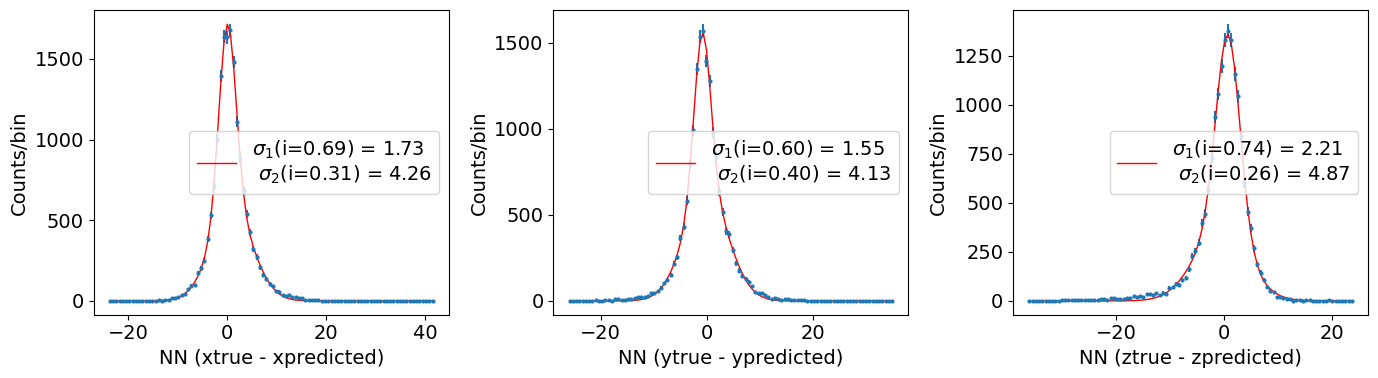

In [205]:
f2gz, f2gx, f2gy = fit_tdeltas(tdeltas(delta_x2, delta_y2, delta_z2), bins=100)
plotfxyz(f2gx, f2gy, f2gz, figsize=(14, 4))

## Resnet

In [206]:
model2 = xResNet8(ResBlock, in_channels=1, out_channels=64, num_classes = 6, 
                 dropout_fraction=0.25, debug=True, dropout=True).to(device)

 ## make_layer 1: planes = 64,  blocks = 1, stride = 1
 ## make_layer: in_planes=64
 ## make_layer: downsample = None
 ## make_layer 2: planes = 128,  blocks = 1, stride = 2
 ## make_layer: in_planes=64
 ## make_layer: downsample = Sequential(
  (0): Conv2d(64, 128, kernel_size=(1, 1), stride=(2, 2))
  (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
)
 ## make_layer 3: planes = 256,  blocks = 1, stride = 2
 ## make_layer: in_planes=128
 ## make_layer: downsample = Sequential(
  (0): Conv2d(128, 256, kernel_size=(1, 1), stride=(2, 2))
  (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
)
 ## make_layer 4: planes = 512,  blocks = 1, stride = 2
 ## make_layer: in_planes=256
 ## make_layer: downsample = Sequential(
  (0): Conv2d(256, 512, kernel_size=(1, 1), stride=(2, 2))
  (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
)


In [207]:
optimizer = optim.Adam(model2.parameters(), lr=0.001)
criterion = nn.MSELoss()

In [208]:
train_losses, val_losses = train_cnn(train_loader, val_loader, model2, optimizer, device, criterion, 
                                     batch_size, epochs=20, iprnt=100)

Training with  ->117400 images
size of train loader  ->1174 images
Evaluating with  ->33600 images
size of eval loader  ->336 images
Running for epochs ->20

EPOCH 0
  ResNet8: input data shape =>torch.Size([100, 1, 8, 8])
  ResNet8: after conv1 =>torch.Size([100, 64, 8, 8])
  ResNet8: after layer0 =>torch.Size([100, 64, 8, 8])
  ResNet8: after layer1 =>torch.Size([100, 128, 4, 4])
  ResNet8: after layer2 =>torch.Size([100, 256, 2, 2])
  ResNet8: after layer3 =>torch.Size([100, 512, 1, 1])
  ResNet8: after avgpool =>torch.Size([100, 512, 1, 1])
  ResNet8: after flatten =>torch.Size([100, 512])
  ResNet8: after fc =>torch.Size([100, 6])
--- EPOCH 0 AVG TRAIN LOSS: 30.927653363859836
--- EPOCH 0 AVG VAL LOSS: 25.154386310350326

EPOCH 1
--- EPOCH 1 AVG TRAIN LOSS: 21.866580041141283
--- EPOCH 1 AVG VAL LOSS: 19.17364069109871

EPOCH 2
--- EPOCH 2 AVG TRAIN LOSS: 20.751950606779914
--- EPOCH 2 AVG VAL LOSS: 19.6914126986549

EPOCH 3
--- EPOCH 3 AVG TRAIN LOSS: 20.099151319701992
--- EPOCH

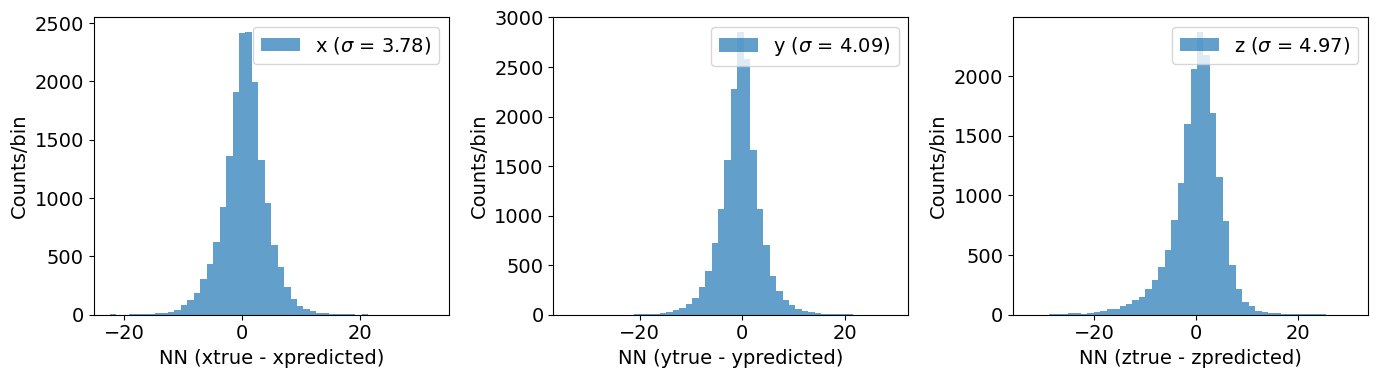

In [209]:
td12 =evaluate_2c_cnn(test_loader, model2, device)
delta_x1 = td12.true_x1 - td12.pred_x1
delta_y1 = td12.true_y1 - td12.pred_y1
delta_z1 = td12.true_z1 - td12.pred_z1
plotxyz(tdeltas(delta_x1, delta_y1, delta_z1), nbins=50)

2g fit: mu1 = 1.00, sigma = 2.86, n1  =0.80
2g fit: mu2 = -1.00, sigma = 6.68, n1  =0.20
weighted error: = 3.62
2g fit: mu1 = 0.61, sigma = 1.67, n1  =0.50
2g fit: mu2 = 0.40, sigma = 4.06, n1  =0.50
weighted error: = 2.87
2g fit: mu1 = 0.02, sigma = 1.44, n1  =0.47
2g fit: mu2 = -0.45, sigma = 3.99, n1  =0.53
weighted error: = 2.80


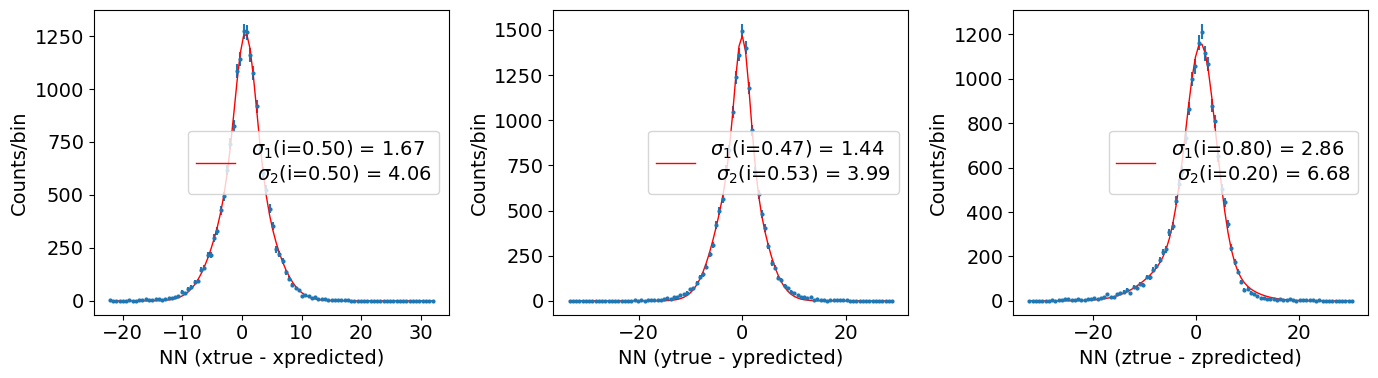

In [210]:
f2gz, f2gx, f2gy = fit_tdeltas(tdeltas(delta_x1, delta_y1, delta_z1), bins=100)
plotfxyz(f2gx, f2gy, f2gz, figsize=(14, 4))

## Classification

In [211]:
dataset = XDataset(dir_root, first_file, last_file,norm=False)  

Running XDataset with norm = False
directory for 1c = /home/investigator/Data/monolithic_csi/CsI_6x6_fullwrap_50k_0MHzDC_PTFE_LUT_gamma_vox_12mm/df1c, 2c = /home/investigator/Data/monolithic_csi/CsI_6x6_fullwrap_50k_0MHzDC_PTFE_LUT_gamma_vox_12mm/df2c, >2c = /home/investigator/Data/monolithic_csi/CsI_6x6_fullwrap_50k_0MHzDC_PTFE_LUT_gamma_vox_12mm/dfnc
 Image type = 0
 Image type = 1
 Image type = 1
Before shufle: length si: 512770, si->[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
After shufle: length si: 512770, si->[115481, 208736, 461043, 162373, 418200, 479114, 338695, 506523, 461126, 152977]


In [212]:
dataset[3]

(tensor([[[198., 228., 246., 223., 214., 186., 171., 148.],
          [231., 273., 279., 259., 226., 175., 193., 155.],
          [247., 259., 300., 285., 251., 202., 193., 170.],
          [240., 277., 262., 265., 250., 219., 170., 153.],
          [228., 246., 235., 220., 249., 231., 171., 174.],
          [192., 199., 243., 208., 211., 211., 167., 166.],
          [184., 159., 209., 198., 174., 159., 164., 143.],
          [146., 187., 199., 185., 171., 149., 131., 125.]]]),
 tensor(0))

In [213]:
data_loader, train_loader, val_loader, test_loader = mono_data_loader(dataset, 
                                                                      batch_size=batch_size, 
                                                                      train_fraction=train_fraction, 
                                                                      val_fraction=val_fraction)

Loaded 512770 events
 train size = 358939
 val size = 102554
 test size = 51277
 train indices = range(0, 358939)
 val indices = range(358939, 461493)
 test indices = range(461493, 512770)
358939 training events (70.0%)
102554 validation events (20.0%)
51277 test events (10.0%)


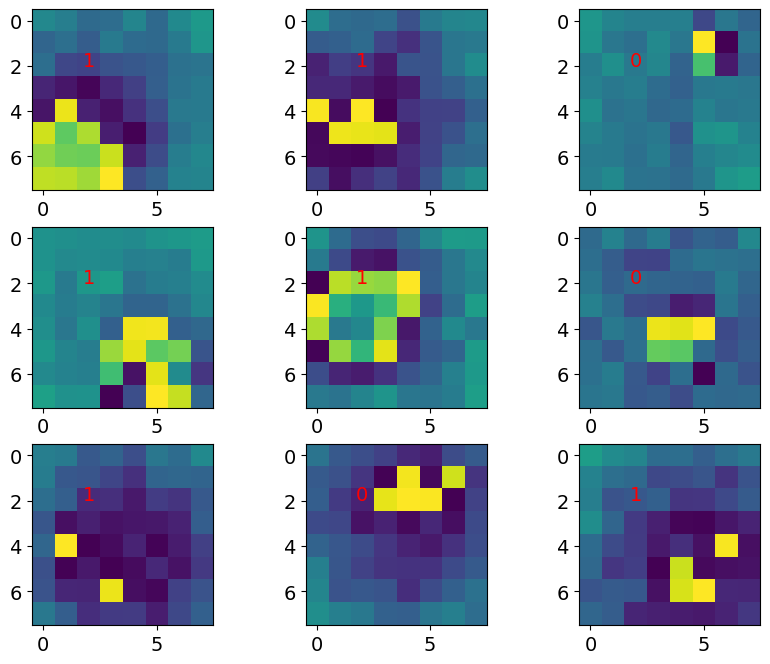

In [214]:
plot_images_and_labels(train_loader, start=100, figsize=(10, 8))

In [38]:
model = CNN(clyrs,llyrs).to(device)

In [224]:
summary(modelx,(1,8,8))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1             [-1, 64, 8, 8]             640
       BatchNorm2d-2             [-1, 64, 8, 8]             128
              ReLU-3             [-1, 64, 8, 8]               0
         MaxPool2d-4             [-1, 64, 4, 4]               0
            Conv2d-5            [-1, 128, 4, 4]          73,856
       BatchNorm2d-6            [-1, 128, 4, 4]             256
              ReLU-7            [-1, 128, 4, 4]               0
         MaxPool2d-8            [-1, 128, 2, 2]               0
            Conv2d-9            [-1, 256, 3, 3]         131,328
      BatchNorm2d-10            [-1, 256, 3, 3]             512
             ReLU-11            [-1, 256, 3, 3]               0
        MaxPool2d-12            [-1, 256, 1, 1]               0
           Conv2d-13            [-1, 512, 2, 2]         524,800
      BatchNorm2d-14            [-1, 51

In [225]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(modelx.parameters(), lr=0.01, weight_decay = 0.001, momentum = 0.9)  


In [226]:
x_single_run(train_loader, device, model, optimizer, criterion, xc=True)

** Run for 1 event**
epoch = 0
i = 0
labels shape = torch.Size([100])
imgs shape = torch.Size([100, 1, 8, 8])
labels = tensor([1, 0, 0, 1, 0, 1, 0, 0, 1, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0,
        0, 1, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 0, 1, 0, 0, 1,
        1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 1, 0, 1, 0, 1, 0, 1,
        0, 1, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1,
        0, 0, 1, 0])
outputs = torch.Size([100, 3])
predicted label = tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        2, 1, 1, 0, 1, 2, 1, 1, 2, 1, 2, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1,
        1, 2, 1, 2, 1, 1, 1, 1, 2, 1, 2, 1, 1, 2, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 2, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 2,
        2, 1, 1, 1], device='cuda:0')
correct = 32
Train Step 1/3590, Loss: 1.1091334819793701
i = 1
labels shape = torch.Size([100])
imgs shape = torch.Size([100, 1, 8, 8

In [227]:
train_losses, val_losses, acc = x_train_cnn(train_loader, val_loader, modelx, optimizer, device, criterion, 
                                            batch_size=64, xc=True,
                                            iprnt=100, epochs=10)

Training with  ->229760 images
size of train loader  ->3590 images
Evaluating with  ->65664 images
size of eval loader  ->1026 images
Classification  ->True
Running for epochs ->10

EPOCH 0
training step: size of sample 3590
Validation step: size of sample 1026
--- EPOCH 0 AVG TRAIN LOSS: 0.6432508803011647
--- EPOCH 0 AVG VAL LOSS: 0.6194528091488294
Accuracy on the 1026 validation images: 65.23587573375977 %

EPOCH 1
training step: size of sample 3590
Validation step: size of sample 1026
--- EPOCH 1 AVG TRAIN LOSS: 0.6157789945187343
--- EPOCH 1 AVG VAL LOSS: 0.6072487829953839
Accuracy on the 1026 validation images: 66.716071533046 %

EPOCH 2
training step: size of sample 3590
Validation step: size of sample 1026
--- EPOCH 2 AVG TRAIN LOSS: 0.6069532998674095
--- EPOCH 2 AVG VAL LOSS: 0.608467973289434
Accuracy on the 1026 validation images: 66.3026308091347 %

EPOCH 3
training step: size of sample 3590
Validation step: size of sample 1026
--- EPOCH 3 AVG TRAIN LOSS: 0.6019900270574

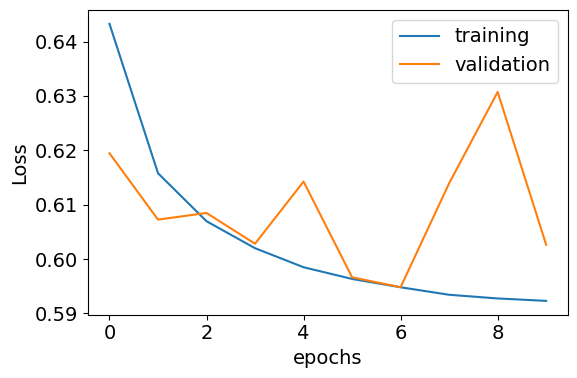

In [228]:
plot_loss(10, train_losses, val_losses,figsize=(6, 4))

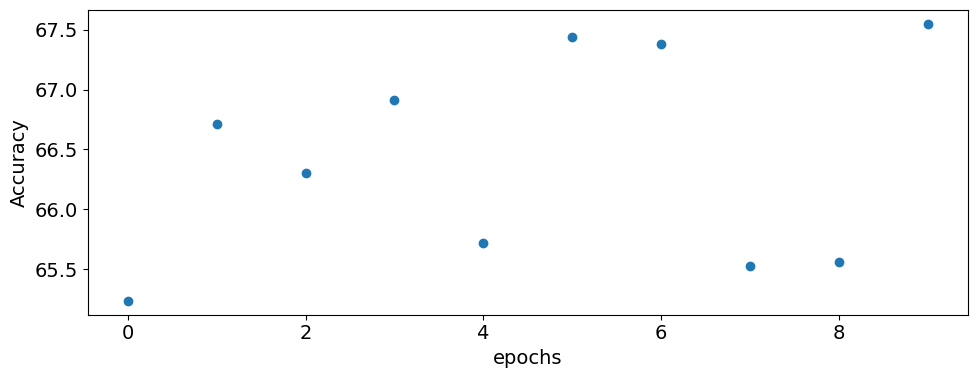

In [229]:
plot_accuracy(acc, figsize=(10, 4))

## Normalization

In [230]:
means, stds = get_means_stds2(dir=d1c)

files in dir: 100
shape -> (3027, 8, 8)
mean img0 =205.46875
std  img0 =33.66422653198242


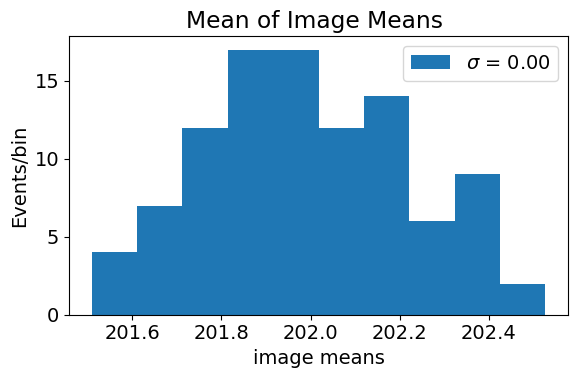

In [231]:
meansx =[np.mean(x) for x in means]
histoplot(meansx, "image means", vart="Mean of Image Means ", num_bins = 10, figsize=(6, 4))

In [232]:
imean = np.mean(meansx)

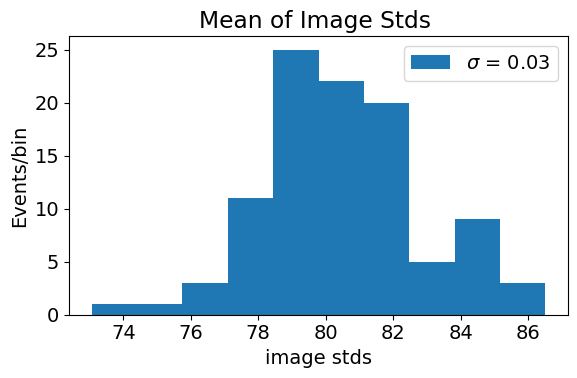

In [233]:
stdsx =[np.std(x) for x in stds]
histoplot(stdsx, "image stds", vart="Mean of Image Stds ", num_bins = 10, figsize=(6, 4))

In [234]:
isigma = np.mean(stdsx)

In [235]:
print(f"Normalization: mean = {imean}, std = {isigma}")

Normalization: mean = 201.99266052246094, std = 80.52242279052734


In [236]:
means2, stds2 = get_means_stds2(dir=d2c)

files in dir: 100
shape -> (1682, 8, 8)
mean img0 =199.0625
std  img0 =37.01303482055664


In [237]:
folder_h5    = "CsI_6x6_fullwrap_50k_0MHzDC_PTFE_LUT_gamma_h5"

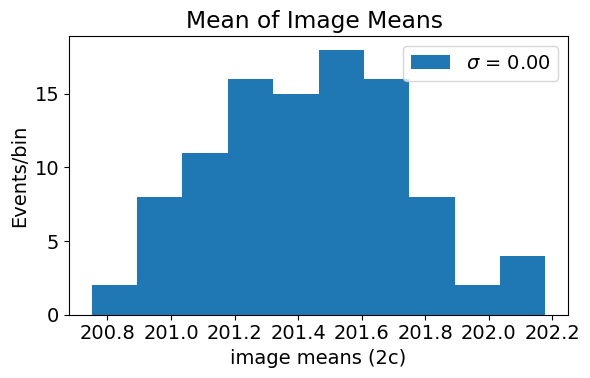

In [238]:
meansx2 =[np.mean(x) for x in means2]
histoplot(meansx2, "image means (2c)", vart="Mean of Image Means ", num_bins = 10, figsize=(6, 4))

In [239]:
imean2 = np.mean(meansx2)

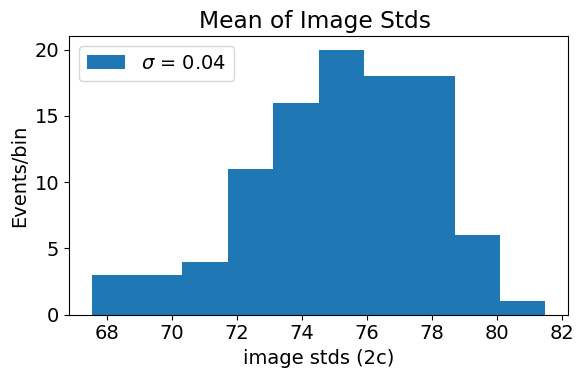

In [240]:
stdsx2 =[np.std(x) for x in stds2]
histoplot(stdsx2, "image stds (2c)", vart="Mean of Image Stds ", num_bins = 10, figsize=(6, 4))

In [241]:
isigma2 = np.mean(stdsx2)

In [242]:
print(f"Normalization 2c: mean = {imean2}, std = {isigma2}")

Normalization 2c: mean = 201.4387664794922, std = 75.14452362060547


In [243]:
means3, stds3 = get_means_stds2(dir=dnc)

files in dir: 100
shape -> (382, 8, 8)
mean img0 =199.28125
std  img0 =51.78937911987305


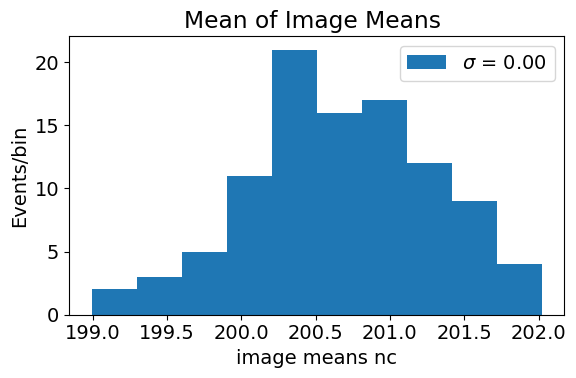

In [244]:
meansx3 =[np.mean(x) for x in means3]
histoplot(meansx3, "image means nc", vart="Mean of Image Means ", num_bins = 10, figsize=(6, 4))

In [245]:
imean3 = np.mean(meansx3)

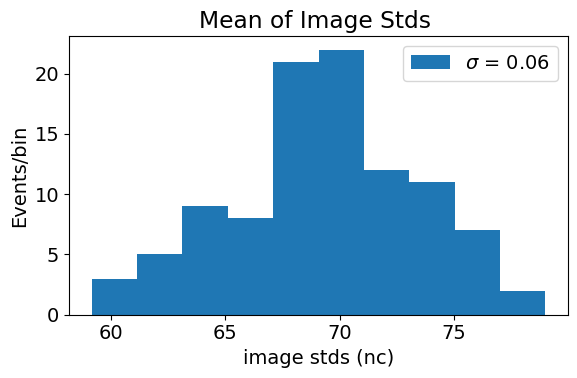

In [246]:
stdsx3 =[np.std(x) for x in stds3]
histoplot(stdsx3, "image stds (nc)", vart="Mean of Image Stds ", num_bins = 10, figsize=(6, 4))

In [247]:
isigma3 = np.mean(stdsx3)

In [248]:
print(f"Normalization nc: mean = {imean3}, std = {isigma3}")

Normalization nc: mean = 200.6782684326172, std = 69.30697631835938


### Run with full stats and normalization

In [249]:
dataset = XDataset(dir_root, first_file, last_file,norm=True, mean=imean, std=isigma)  # No comparison with energy only xyz


Running XDataset with norm = True
directory for 1c = /home/investigator/Data/monolithic_csi/CsI_6x6_fullwrap_50k_0MHzDC_PTFE_LUT_gamma_vox_12mm/df1c, 2c = /home/investigator/Data/monolithic_csi/CsI_6x6_fullwrap_50k_0MHzDC_PTFE_LUT_gamma_vox_12mm/df2c, >2c = /home/investigator/Data/monolithic_csi/CsI_6x6_fullwrap_50k_0MHzDC_PTFE_LUT_gamma_vox_12mm/dfnc
 Image type = 0
 Image type = 1
 Image type = 1
Before shufle: length si: 512770, si->[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
After shufle: length si: 512770, si->[115481, 208736, 461043, 162373, 418200, 479114, 338695, 506523, 461126, 152977]


In [250]:
dataset[3]

(tensor([[[-4.9584e-02,  3.2298e-01,  5.4652e-01,  2.6089e-01,  1.4912e-01,
           -1.9861e-01, -3.8489e-01, -6.7053e-01],
          [ 3.6024e-01,  8.8183e-01,  9.5635e-01,  7.0797e-01,  2.9814e-01,
           -3.3522e-01, -1.1168e-01, -5.8360e-01],
          [ 5.5894e-01,  7.0797e-01,  1.2171e+00,  1.0309e+00,  6.0862e-01,
            9.1148e-05, -1.1168e-01, -3.9731e-01],
          [ 4.7201e-01,  9.3151e-01,  7.4523e-01,  7.8248e-01,  5.9620e-01,
            2.1121e-01, -3.9731e-01, -6.0843e-01],
          [ 3.2298e-01,  5.4652e-01,  4.0991e-01,  2.2363e-01,  5.8378e-01,
            3.6024e-01, -3.8489e-01, -3.4764e-01],
          [-1.2410e-01, -3.7166e-02,  5.0927e-01,  7.4605e-02,  1.1186e-01,
            1.1186e-01, -4.3457e-01, -4.4699e-01],
          [-2.2345e-01, -5.3392e-01,  8.7023e-02, -4.9584e-02, -3.4764e-01,
           -5.3392e-01, -4.7183e-01, -7.3262e-01],
          [-6.9537e-01, -1.8619e-01, -3.7166e-02, -2.1103e-01, -3.8489e-01,
           -6.5811e-01, -8.8165e-01

In [251]:
data_loader, train_loader, val_loader, test_loader = mono_data_loader(dataset, 
                                                                      batch_size=batch_size, 
                                                                      train_fraction=train_fraction, 
                                                                      val_fraction=val_fraction)

Loaded 512770 events
 train size = 358939
 val size = 102554
 test size = 51277
 train indices = range(0, 358939)
 val indices = range(358939, 461493)
 test indices = range(461493, 512770)
358939 training events (70.0%)
102554 validation events (20.0%)
51277 test events (10.0%)


In [254]:
modelx = xCNN(clyrs,llyrsx).to(device)

In [255]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(modelx.parameters(), lr=0.01, weight_decay = 0.001, momentum = 0.9)  


In [256]:
train_losses, val_losses, acc = x_train_cnn(train_loader, val_loader, modelx, optimizer, device, criterion, 
                                            batch_size=64, xc=True,
                                            iprnt=100, epochs=10)

Training with  ->229760 images
size of train loader  ->3590 images
Evaluating with  ->65664 images
size of eval loader  ->1026 images
Classification  ->True
Running for epochs ->10

EPOCH 0
training step: size of sample 3590
Validation step: size of sample 1026
--- EPOCH 0 AVG TRAIN LOSS: 0.5920797410200566
--- EPOCH 0 AVG VAL LOSS: 0.5824538770823451
Accuracy on the 1026 validation images: 68.72866977397274 %

EPOCH 1
training step: size of sample 3590
Validation step: size of sample 1026
--- EPOCH 1 AVG TRAIN LOSS: 0.5889770638975924
--- EPOCH 1 AVG VAL LOSS: 0.5863201414283953
Accuracy on the 1026 validation images: 68.40688807847573 %

EPOCH 2
training step: size of sample 3590
Validation step: size of sample 1026
--- EPOCH 2 AVG TRAIN LOSS: 0.5885834292947084
--- EPOCH 2 AVG VAL LOSS: 0.5839827657326853
Accuracy on the 1026 validation images: 68.69161612418823 %

EPOCH 3
training step: size of sample 3590
Validation step: size of sample 1026
--- EPOCH 3 AVG TRAIN LOSS: 0.586564110

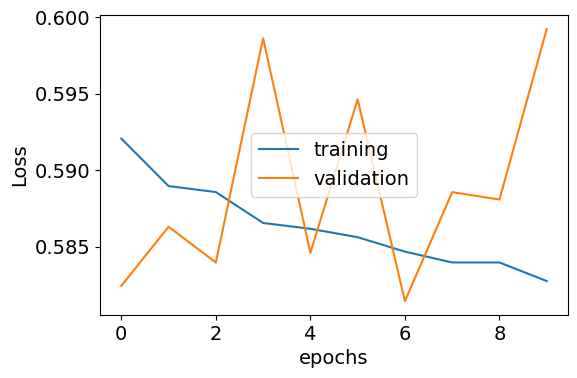

In [257]:
plot_loss(10, train_losses, val_losses,figsize=(6, 4))

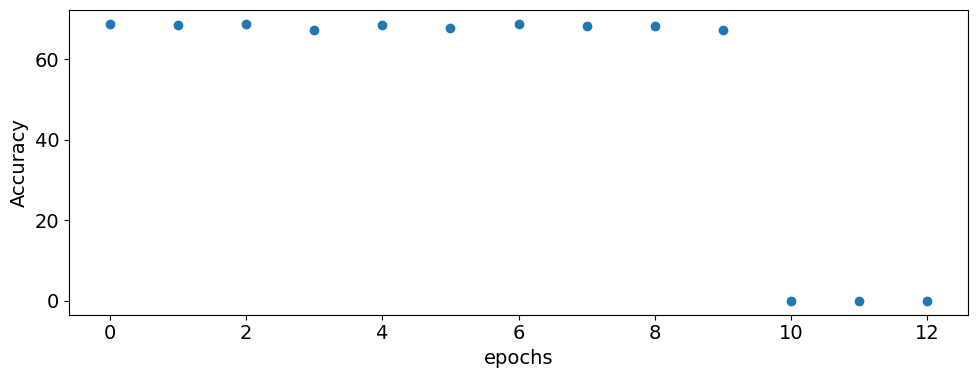

In [261]:
plot_accuracy(acc,figsize=(10, 4))

## Resnet

In [264]:
modelx = xResNet8(ResBlock, in_channels=1, out_channels=64, num_classes = 2, 
                 dropout_fraction=0.25, debug=True, dropout=True).to(device)

 ## make_layer 1: planes = 64,  blocks = 1, stride = 1
 ## make_layer: in_planes=64
 ## make_layer: downsample = None
 ## make_layer 2: planes = 128,  blocks = 1, stride = 2
 ## make_layer: in_planes=64
 ## make_layer: downsample = Sequential(
  (0): Conv2d(64, 128, kernel_size=(1, 1), stride=(2, 2))
  (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
)
 ## make_layer 3: planes = 256,  blocks = 1, stride = 2
 ## make_layer: in_planes=128
 ## make_layer: downsample = Sequential(
  (0): Conv2d(128, 256, kernel_size=(1, 1), stride=(2, 2))
  (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
)
 ## make_layer 4: planes = 512,  blocks = 1, stride = 2
 ## make_layer: in_planes=256
 ## make_layer: downsample = Sequential(
  (0): Conv2d(256, 512, kernel_size=(1, 1), stride=(2, 2))
  (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
)


In [265]:
summary(modelx,(1,8,8))

  ResNet8: input data shape =>torch.Size([2, 1, 8, 8])
  ResNet8: after conv1 =>torch.Size([2, 64, 8, 8])
  ResNet8: after layer0 =>torch.Size([2, 64, 8, 8])
  ResNet8: after layer1 =>torch.Size([2, 128, 4, 4])
  ResNet8: after layer2 =>torch.Size([2, 256, 2, 2])
  ResNet8: after layer3 =>torch.Size([2, 512, 1, 1])
  ResNet8: after avgpool =>torch.Size([2, 512, 1, 1])
  ResNet8: after flatten =>torch.Size([2, 512])
  ResNet8: after fc =>torch.Size([2, 2])
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1             [-1, 64, 8, 8]             640
       BatchNorm2d-2             [-1, 64, 8, 8]             128
              ReLU-3             [-1, 64, 8, 8]               0
            Conv2d-4             [-1, 64, 8, 8]          36,928
       BatchNorm2d-5             [-1, 64, 8, 8]             128
              ReLU-6             [-1, 64, 8, 8]               0
            Conv2d-7       

In [266]:
optimizer= optim.Adam(modelx.parameters(), lr=0.001)

In [267]:
train_losses, val_losses, acc = x_train_cnn(train_loader, val_loader, modelx, optimizer, device, criterion, 
                                            batch_size=64, xc=True,
                                            iprnt=100, epochs=10)

Training with  ->229760 images
size of train loader  ->3590 images
Evaluating with  ->65664 images
size of eval loader  ->1026 images
Classification  ->True
Running for epochs ->10

EPOCH 0
training step: size of sample 3590
Validation step: size of sample 1026
--- EPOCH 0 AVG TRAIN LOSS: 0.6245760484824273
--- EPOCH 0 AVG VAL LOSS: 0.5938851587314588
Accuracy on the 1026 validation images: 67.6248610488133 %

EPOCH 1
training step: size of sample 3590
Validation step: size of sample 1026
--- EPOCH 1 AVG TRAIN LOSS: 0.5882317860727523
--- EPOCH 1 AVG VAL LOSS: 0.5795969873027728
Accuracy on the 1026 validation images: 68.81935370634008 %

EPOCH 2
training step: size of sample 3590
Validation step: size of sample 1026
--- EPOCH 2 AVG TRAIN LOSS: 0.5776797405275462
--- EPOCH 2 AVG VAL LOSS: 0.5803349299853773
Accuracy on the 1026 validation images: 68.83690543518537 %

EPOCH 3
training step: size of sample 3590
Validation step: size of sample 1026
--- EPOCH 3 AVG TRAIN LOSS: 0.5689500268

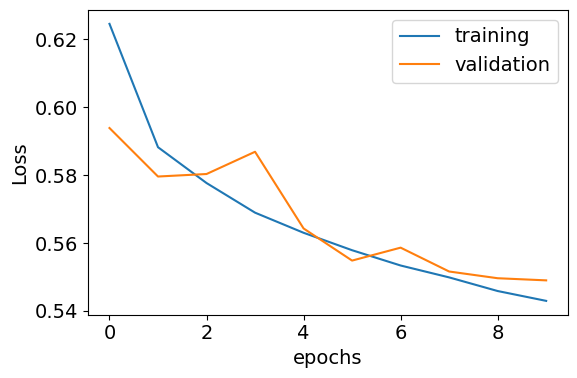

In [268]:
plot_loss(10, train_losses, val_losses,figsize=(6, 4))

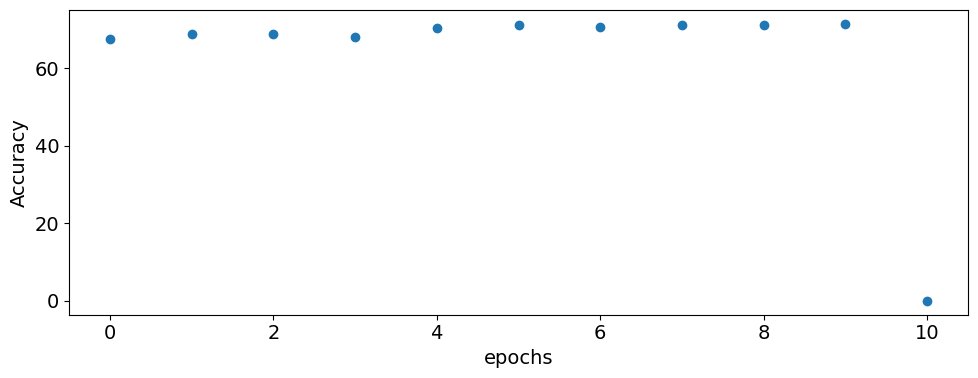

In [269]:
plot_accuracy(acc,figsize=(10, 4))

## Study accuracy

In [270]:
dataset1c = XDataset(dir_root, first_file, last_file, type="1c", norm=False)  

Running XDataset with norm = False
directory for 1c = /home/investigator/Data/monolithic_csi/CsI_6x6_fullwrap_50k_0MHzDC_PTFE_LUT_gamma_vox_12mm/df1c, 2c = /home/investigator/Data/monolithic_csi/CsI_6x6_fullwrap_50k_0MHzDC_PTFE_LUT_gamma_vox_12mm/df2c, >2c = /home/investigator/Data/monolithic_csi/CsI_6x6_fullwrap_50k_0MHzDC_PTFE_LUT_gamma_vox_12mm/dfnc
 Image type = 0
Before shufle: length si: 305080, si->[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
After shufle: length si: 305080, si->[187431, 187255, 204628, 170887, 44287, 157519, 141100, 226100, 210928, 180817]


In [271]:
data_loader = DataLoader(dataset1c, batch_size=10, shuffle=False) # data already shuffled

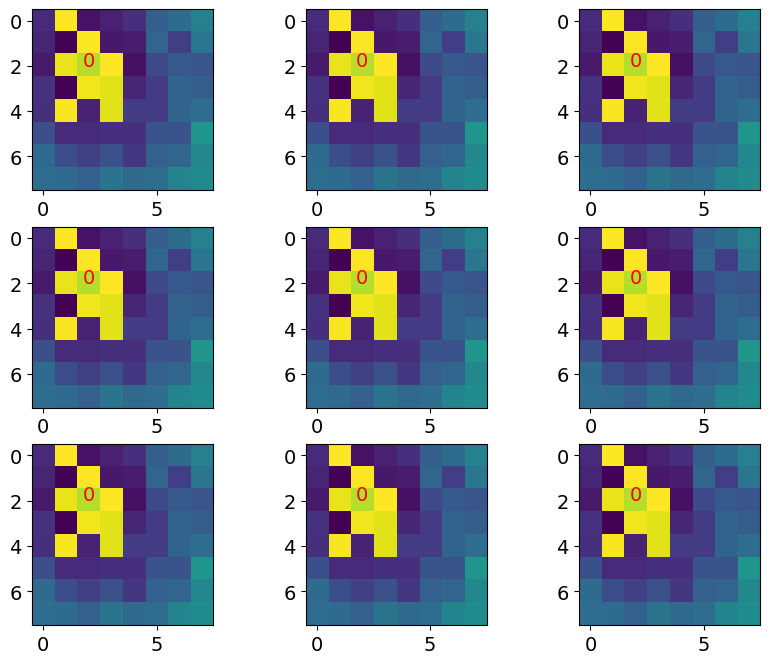

In [272]:
plot_images_and_labels(data_loader, start=0, figsize=(10, 8))

In [273]:
total, t1c, t2c, acc, c1c, c2c = cnn_xeval(test_loader, modelx, device, prnt=1000) 
print(f"Events analyzed = {total}: 1c = {t1c}, 2c = {t2c}")
print(f"Events correctly identified = {acc}")
print(f"1c correctly identified as 1c = {c1c}")
print(f"2c correctly identified as 2c = {c2c}")

Validation step: size of sample 513
i = 0
labels = tensor([0, 0, 1, 0, 0, 1, 1, 0, 1, 0, 1, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 1, 0,
        0, 0, 1, 1, 0, 1, 1, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0,
        1, 0, 1, 0, 1, 1, 0, 0, 1, 0, 0, 1, 1, 1, 1, 0, 0, 0, 1, 0, 1, 0, 0, 1,
        1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1,
        1, 1, 0, 0], device='cuda:0')
predicted = tensor([0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0,
        0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0,
        1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0,
        1, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0,
        0, 0, 1, 0], device='cuda:0')
correct = 65
labels 0 = tensor([ 0,  1,  3,  4,  7,  9, 12, 13, 15, 16, 17, 19, 20, 23, 24, 25, 28, 31,
        34, 35, 36, 38, 39, 41, 42, 43, 45, 46, 47, 49, 51, 54, 55, 57, 58, 63,
        64, 65, 67, 69, 70, 73, 74, 7